In [1]:
import sys
import os
import h5py
import numpy as np
import copy
from scipy import signal
import matplotlib.pyplot as plt

# Parameters

In [2]:
PMTS_PER_MPMT = 19
BARREL_MAP_ARRAY_IDXS = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
MPMT_POSITIONS = np.load('/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz')['mpmt_image_positions']
DATA_SIZE = np.insert(np.max(MPMT_POSITIONS, axis=0) + 1, 0, PMTS_PER_MPMT)

# Import Files

In [3]:
h5_truehits = h5py.File("/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5","r")
h5_digihits = h5py.File("/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5","r")

In [4]:
print(f"True hits: {h5_truehits.keys()}")
print(f"Digi hits: {h5_digihits.keys()}")

True hits: <KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_parent', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>
Digi hits: <KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


# Manipulating data

In [5]:
'''
Get data from event - pass in event_id and h5 file (digitised/truehits)
adapted from https://github.com/Whisky-Jack/WatChMaL_analysis/blob/main/short_tank_exploratory_data_analysis/new_dataset/3.%20dataset_analysis%20I.ipynb
'''
def get_event_data_from_index(item, file, h5):
    
    idxs = np.where(np.logical_and(h5["event_ids"][:] == item, h5["root_files"][:] == file))[0]
    if idxs.any():
        idx = idxs[0]
    else:
        raise LookupError("event_id does not exist")
        return
        
    start = h5["event_hits_index"][idx]
    stop  = h5["event_hits_index"][idx + 1]
    
    raw_hit_pmts = h5["hit_pmt"][start:stop].astype(np.int16)
    if "hit_charge" in h5.keys(): # Digitised hits
        hit_pmts = raw_hit_pmts
        hit_charges = h5["hit_charge"][start:stop]
        hit_parents = {} # Empty dict
    else: # True hits - count number of occurrences of each pmt hit, remove duplicates in hit_pmt
        hit_pmts, hit_charges = np.unique(raw_hit_pmts, return_counts = True)
        hit_sources = h5["hit_parent"][start:stop]
        all_parents = np.unique(hit_sources)
        # Dictionary with key = parent, value = array of pmts
        hit_parents = dict(zip(all_parents, [raw_hit_pmts[np.where(hit_sources == x)] for x in all_parents]))

    hit_mpmts = hit_pmts // PMTS_PER_MPMT
    hit_pmt_in_modules = hit_pmts % PMTS_PER_MPMT

    hit_rows = MPMT_POSITIONS[hit_mpmts, 0]
    hit_cols = MPMT_POSITIONS[hit_mpmts, 1]

    sample_data = np.zeros(DATA_SIZE)
    sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

    # fix barrel array indexing to match endcaps in xyz ordering
    sample_data[:, 12:28, :] = sample_data[BARREL_MAP_ARRAY_IDXS, 12:28, :]
    moved_data = np.moveaxis(sample_data, 0, -1)
        
    return hit_pmts, moved_data, hit_charges, hit_parents

In [6]:
# Test event
event_idx = 236
file = h5_truehits["root_files"][event_idx]

pmts_truehits, test_data_truehits, test_data_truehits_raw, hit_parents_truehits = \
    get_event_data_from_index(event_idx, file, h5_truehits)
pmts_digihits, test_data_digihits, test_data_digihits_raw, _ = get_event_data_from_index(event_idx, file, h5_digihits)

print("True hits")
print(pmts_truehits.shape)
print(test_data_truehits.shape)
print(test_data_truehits_raw.shape)
print(hit_parents_truehits)

print("Digitised hits:")
print(pmts_digihits.shape)
print(test_data_digihits.shape)
print(test_data_digihits_raw.shape)


True hits
(1715,)
(29, 40, 19)
(1715,)
{-1: array([2149,  677, 2955, 2148, 3130, 6720, 1054, 1172, 5963, 2722, 7793,
       8387,  673, 1526, 5818, 2856, 6066, 7294, 2598, 6590, 6476, 4254,
       6448, 5447, 1325, 8521, 3374, 2321, 8757,  567, 3321, 6181, 2702,
       4075, 7083, 7390], dtype=int16), 2: array([8370, 8370,  440, ..., 8436, 2255, 2922], dtype=int16), 3: array([ 8370,  2994,   694,   694,   694,  2921,  2921,  2921,  2921,
        2921,  1368,  1368,  1368,  1368,  1368,  1416,  9792,  9792,
        9791,  9797,  9797,  3710,  3710,  2910,  2910,  2910,  2910,
        2941,  2941,  2180,  8371,  1390,  1390,  1390,  1390,  1390,
        1512,  3712,  3712,  3712,  1458,  1458,  9776,  3152,  9566,
        9566,   600,   600,  1363,  1363,  1363,  1363,  5798,  1519,
         496,  2873,  2835,  2835,  2038,  9939,  9939,  9939,   715,
        9801,  2132,  2132,  2132,   606,   606,  2903,  2165,   647,
        9735,  8377,  9951,  9951,  9930,  2045,   515,  9967,  9967

In [7]:
np.unique(h5_truehits["hit_parent"][0:10000])

array([-1,  2,  3], dtype=int32)

# Plotting

In [26]:
sys.path.append('../utils')

from plot_utils import get_plot_array 
from event_plot_utils import PMT_to_flat_cylinder_map_positive, EventDisplay
from matplotlib import cm
from event_plot_utils import get_upper_endcap_tubes, get_lower_endcap_tubes, get_barrel_tubes, EventSubsetDisplay

GEOFILE = np.load('/fast_scratch/WatChMaL/data/geo_mPMTshort.npz', allow_pickle=True)
TUBES = GEOFILE[ 'tube_no' ]
TUBE_XYZ = GEOFILE[ 'position' ]
TUBE_X   = TUBE_XYZ[:,0]
TUBE_Y   = TUBE_XYZ[:,1]
TUBE_Y   = TUBE_XYZ[:,2]
TUBE_DIR = GEOFILE[ 'orientation']
PMT_FLAT_MAP_POSITIVE = PMT_to_flat_cylinder_map_positive( TUBES, TUBE_XYZ )

UPPER_ENDCAP_SUBSET = get_upper_endcap_tubes( TUBES, TUBE_XYZ ) - 1
LOWER_ENDCAP_SUBSET = get_lower_endcap_tubes( TUBES, TUBE_XYZ ) - 1
BARREL_SUBSET       = get_barrel_tubes( TUBES, TUBE_XYZ ) - 1


In [49]:
# TODO: Create custom colourmap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
tab10 = cm.get_cmap('Set1', 6)
newcolors = tab10(np.linspace(0, 1, 6))
black = np.array([0, 0, 0, 1])
newcolors[1,:] = black
print(newcolors)
newcmp = ListedColormap(newcolors)

[[0.89411765 0.10196078 0.10980392 1.        ]
 [0.         0.         0.         1.        ]
 [0.59607843 0.30588235 0.63921569 1.        ]
 [1.         1.         0.2        1.        ]
 [0.96862745 0.50588235 0.74901961 1.        ]
 [0.6        0.6        0.6        1.        ]]


In [55]:
'''
Plots summed values  and individual mpmts for both true and digitised hits
True hits pmts and charges: truehits_pmt, truehits_data 
Digitised hits pmts and charges: digihits_pmt, digihits_data 
optional: title, subset tubes, subset tube names
'''
def plot_charge(truehits_pmt, truehits_data, truehits_data_raw, \
               digihits_pmt, digihits_data, digihits_data_raw, title = None, \
               subset_tubes = [UPPER_ENDCAP_SUBSET, LOWER_ENDCAP_SUBSET, BARREL_SUBSET], \
               subset_names = ["Upper endcap", "Lower endcap", "Barrel"]):

    summed_event_data_truehits = np.sum(truehits_data, axis=-1)
    summed_event_data_digihits = np.sum(digihits_data, axis=-1)

    fig, ax = plt.subplots(1, 2, figsize=(32, 20),facecolor='w')
    ax[0].imshow(summed_event_data_truehits, cmap='jet', origin='lower')
    ax[0].set_title('True hits, charge sum in mPMT', fontsize=30)
    ax[1].imshow(summed_event_data_digihits, cmap='jet', origin='lower')
    ax[1].set_title('Digitised hits, charge sum in mPMT', fontsize=30)
    
    if title: # event index, optional parameter
        fig.suptitle(title, fontsize = 40)
        
    plt.tight_layout()
    plt.show()
    
    # Plot entire map
    EventDisplay(truehits_pmt, truehits_data_raw, PMT_FLAT_MAP_POSITIVE, 
                 title = "Complete - True hits", cutrange = [0, -1])
    EventDisplay(digihits_pmt, digihits_data_raw, PMT_FLAT_MAP_POSITIVE, 
                 title = "Complete - Digitised hits", cutrange = [0, -1])

    # Plot subsets
    for subset, name in zip(subset_tubes, subset_names):
        EventSubsetDisplay(truehits_pmt, truehits_data_raw, PMT_FLAT_MAP_POSITIVE, subset, 
                           title = f"{name}: True hits", cutrange = [0, -1])
        EventSubsetDisplay(digihits_pmt, digihits_data_raw, PMT_FLAT_MAP_POSITIVE, subset, 
                           title = f"{name}: Digitised hits", cutrange = [0, -1])

    
#     event_data_array_truehits = get_plot_array(test_data_truehits)
#     event_data_array_truehits = np.ma.masked_where(event_data_array_truehits < 0.05, event_data_array_truehits)
#     event_data_array_digihits = get_plot_array(test_data_digihits)
#     event_data_array_digihits = np.ma.masked_where(event_data_array_digihits < 0.05, event_data_array_digihits)
#     fig, ax = plt.subplots(2, 1, figsize=(32, 20),facecolor='w')
#     ax[0].imshow(event_data_array_truehits, origin="upper", cmap="viridis")
#     ax[0].set_title('True hits, charge in mPMT', fontsize=20)
#     ax[1].imshow(event_data_array_digihits, origin="upper", cmap="viridis")
#     ax[1].set_title('Digitised hits, charge in mPMT', fontsize=20)
#     plt.show()


'''
Plots parents of all hit pmt. Plots each parent separately, then a combined heatmap with the parent that hit the most times
'''
def plot_parents(hit_parents, hit_charges = None, title = None, \
                subset_tubes = [UPPER_ENDCAP_SUBSET, LOWER_ENDCAP_SUBSET, BARREL_SUBSET], \
                subset_names = ["Upper endcap", "Lower endcap", "Barrel"]):
    
    all_hit_pmts = {} # Key = pmt, value = parent with most hits
    max_count = {}; # Key = pmt, value = num_hits (charge)
    
    for parent, pmts in hit_parents.items():
        pmts, hit_counts = np.unique(pmts, return_counts = True)
        EventDisplay(pmts, hit_counts, PMT_FLAT_MAP_POSITIVE, 
                 title = f"Hits by {parent}", cutrange = [0, -1])
        plt.show()
        
        for ind, x in enumerate(hit_counts): # Update max_count and all_pmts
            pmt = pmts[ind]
            if pmt not in max_count or max_count[pmt] < x: # NOTE: keeps previous value if x = count
                all_hit_pmts[pmt] = parent
                max_count[pmt] = x
    
    # Plot all classes
    all_pmts = np.fromiter(all_hit_pmts.keys(), dtype="int32")
    all_parents = np.fromiter(all_hit_pmts.values(), dtype="int32")
    
    EventDisplay(all_pmts, all_parents, PMT_FLAT_MAP_POSITIVE, 
                 title = f"All hits by parent", cutrange = [-1, -1], cmap = newcmp)

#     Plot subsets
    for subset, name in zip(subset_tubes, subset_names):
        EventSubsetDisplay(all_pmts, all_parents, PMT_FLAT_MAP_POSITIVE, subset, 
                           title = f"{name}: True hits", cutrange = [-1, -1], cmap = newcmp)


def plot_from_idx (event_idx, file):
    try:
        pmts_truehits, test_data_truehits, test_data_truehits_raw, hit_parents_truehits = get_event_data_from_index(event_idx, file, h5_truehits)
        pmts_digihits, test_data_digihits, test_data_digihits_raw, _ = get_event_data_from_index(event_idx, file, h5_digihits)
        plot_charge(pmts_truehits, test_data_truehits, test_data_truehits_raw, pmts_digihits, 
                   test_data_digihits, test_data_digihits_raw, f"Event No. {event_idx} \n from {file}")
        plot_parents(hit_parents_truehits)
    except LookupError:
        print(f"event_ind {event_idx} not found in one or both files")
    

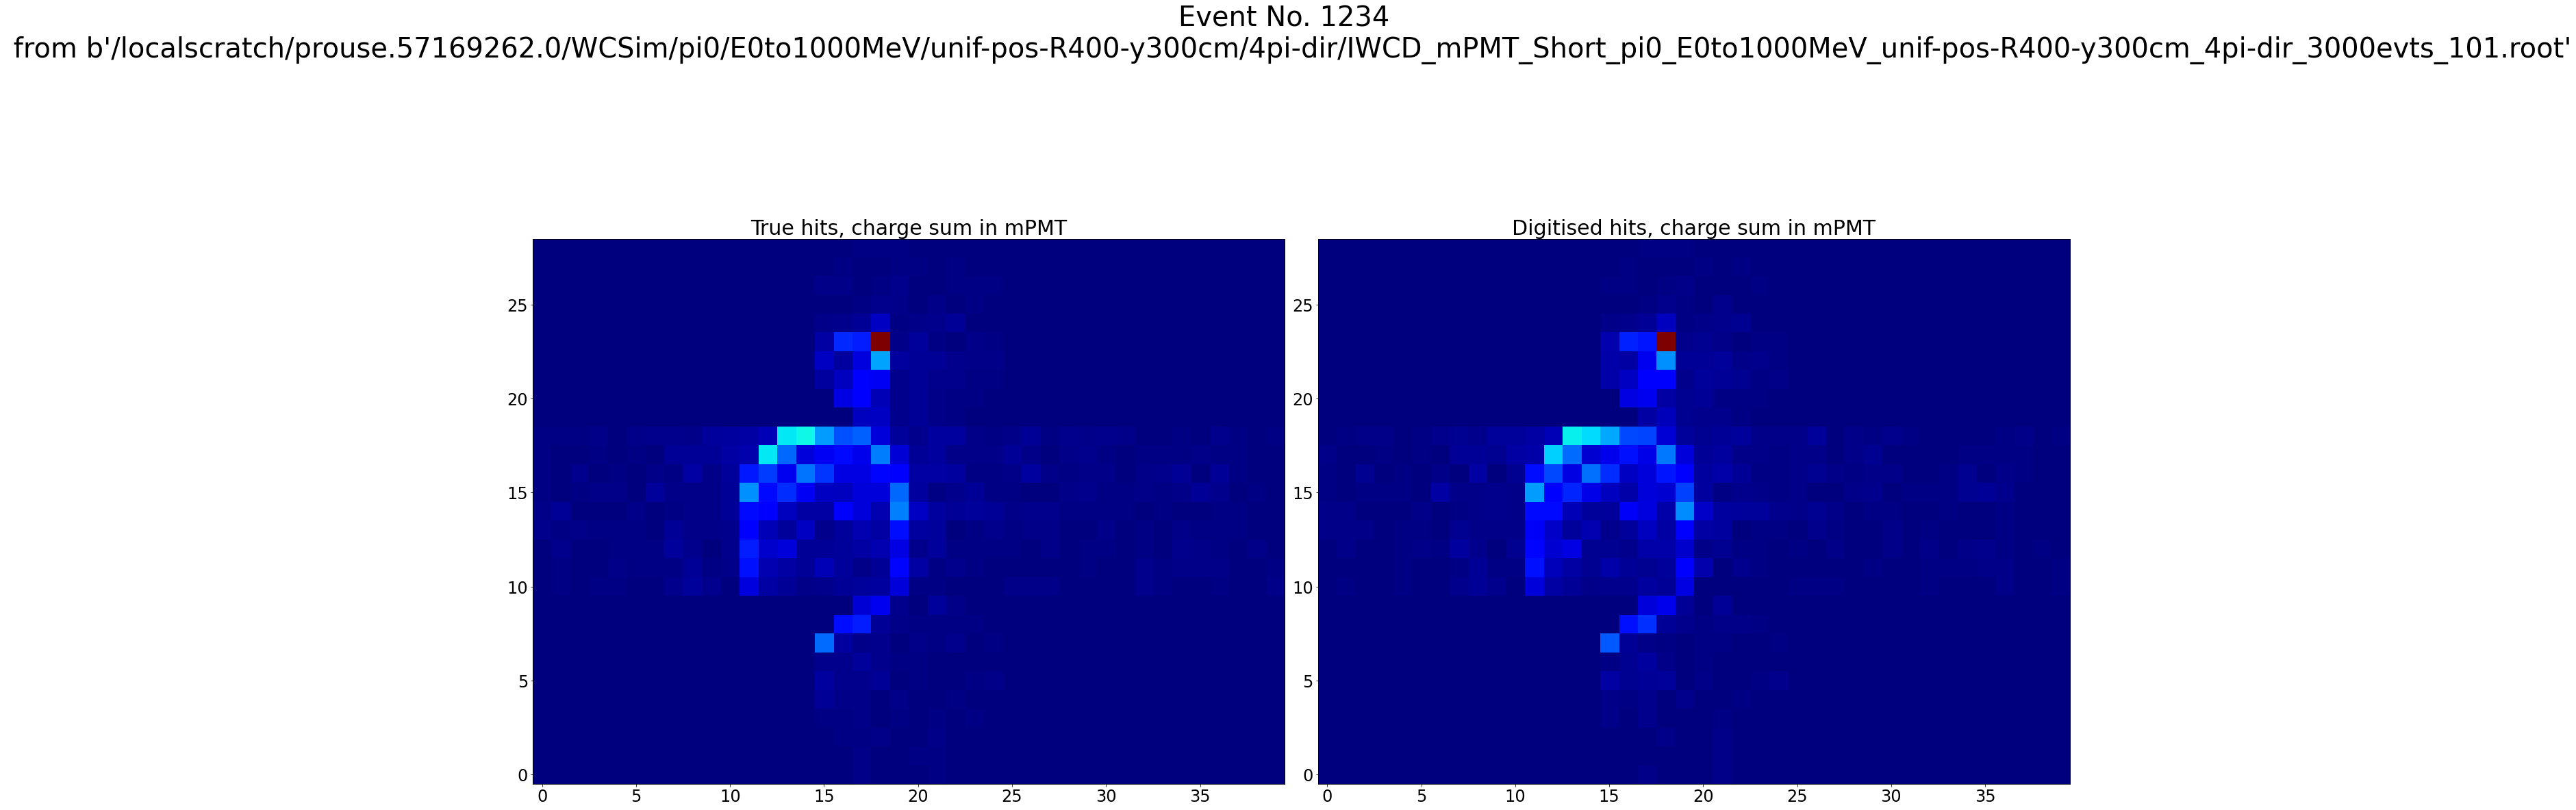

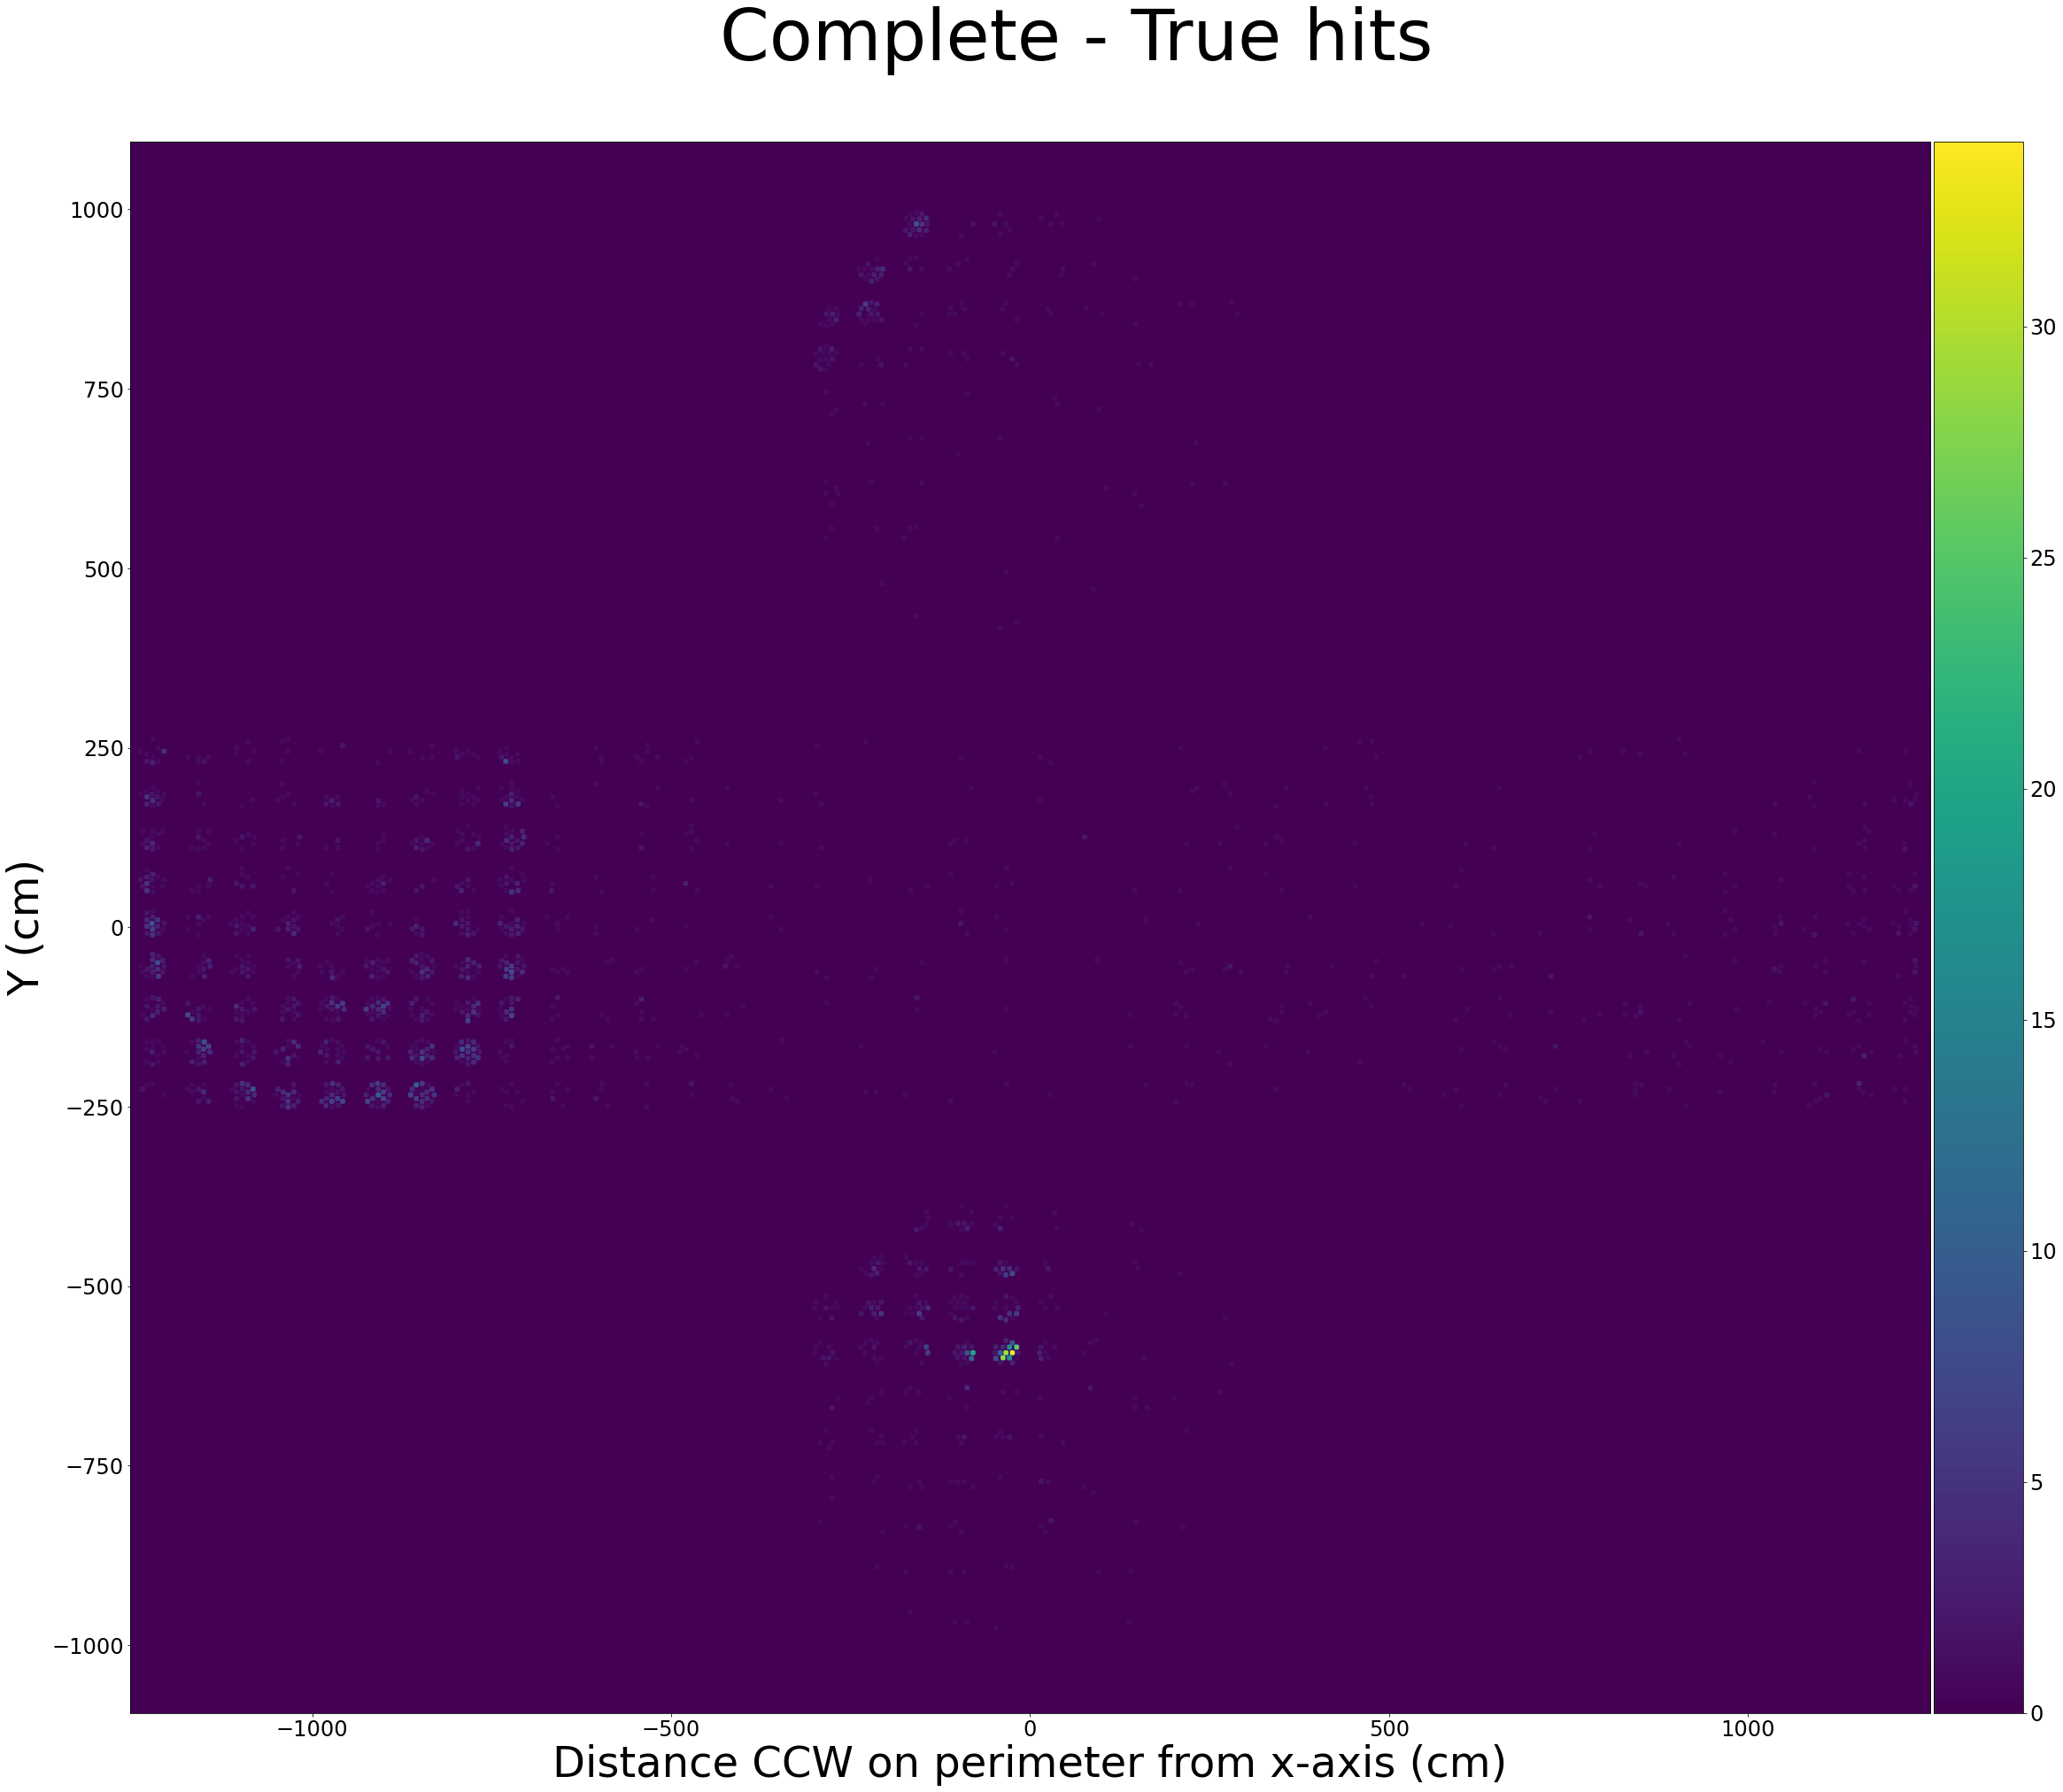

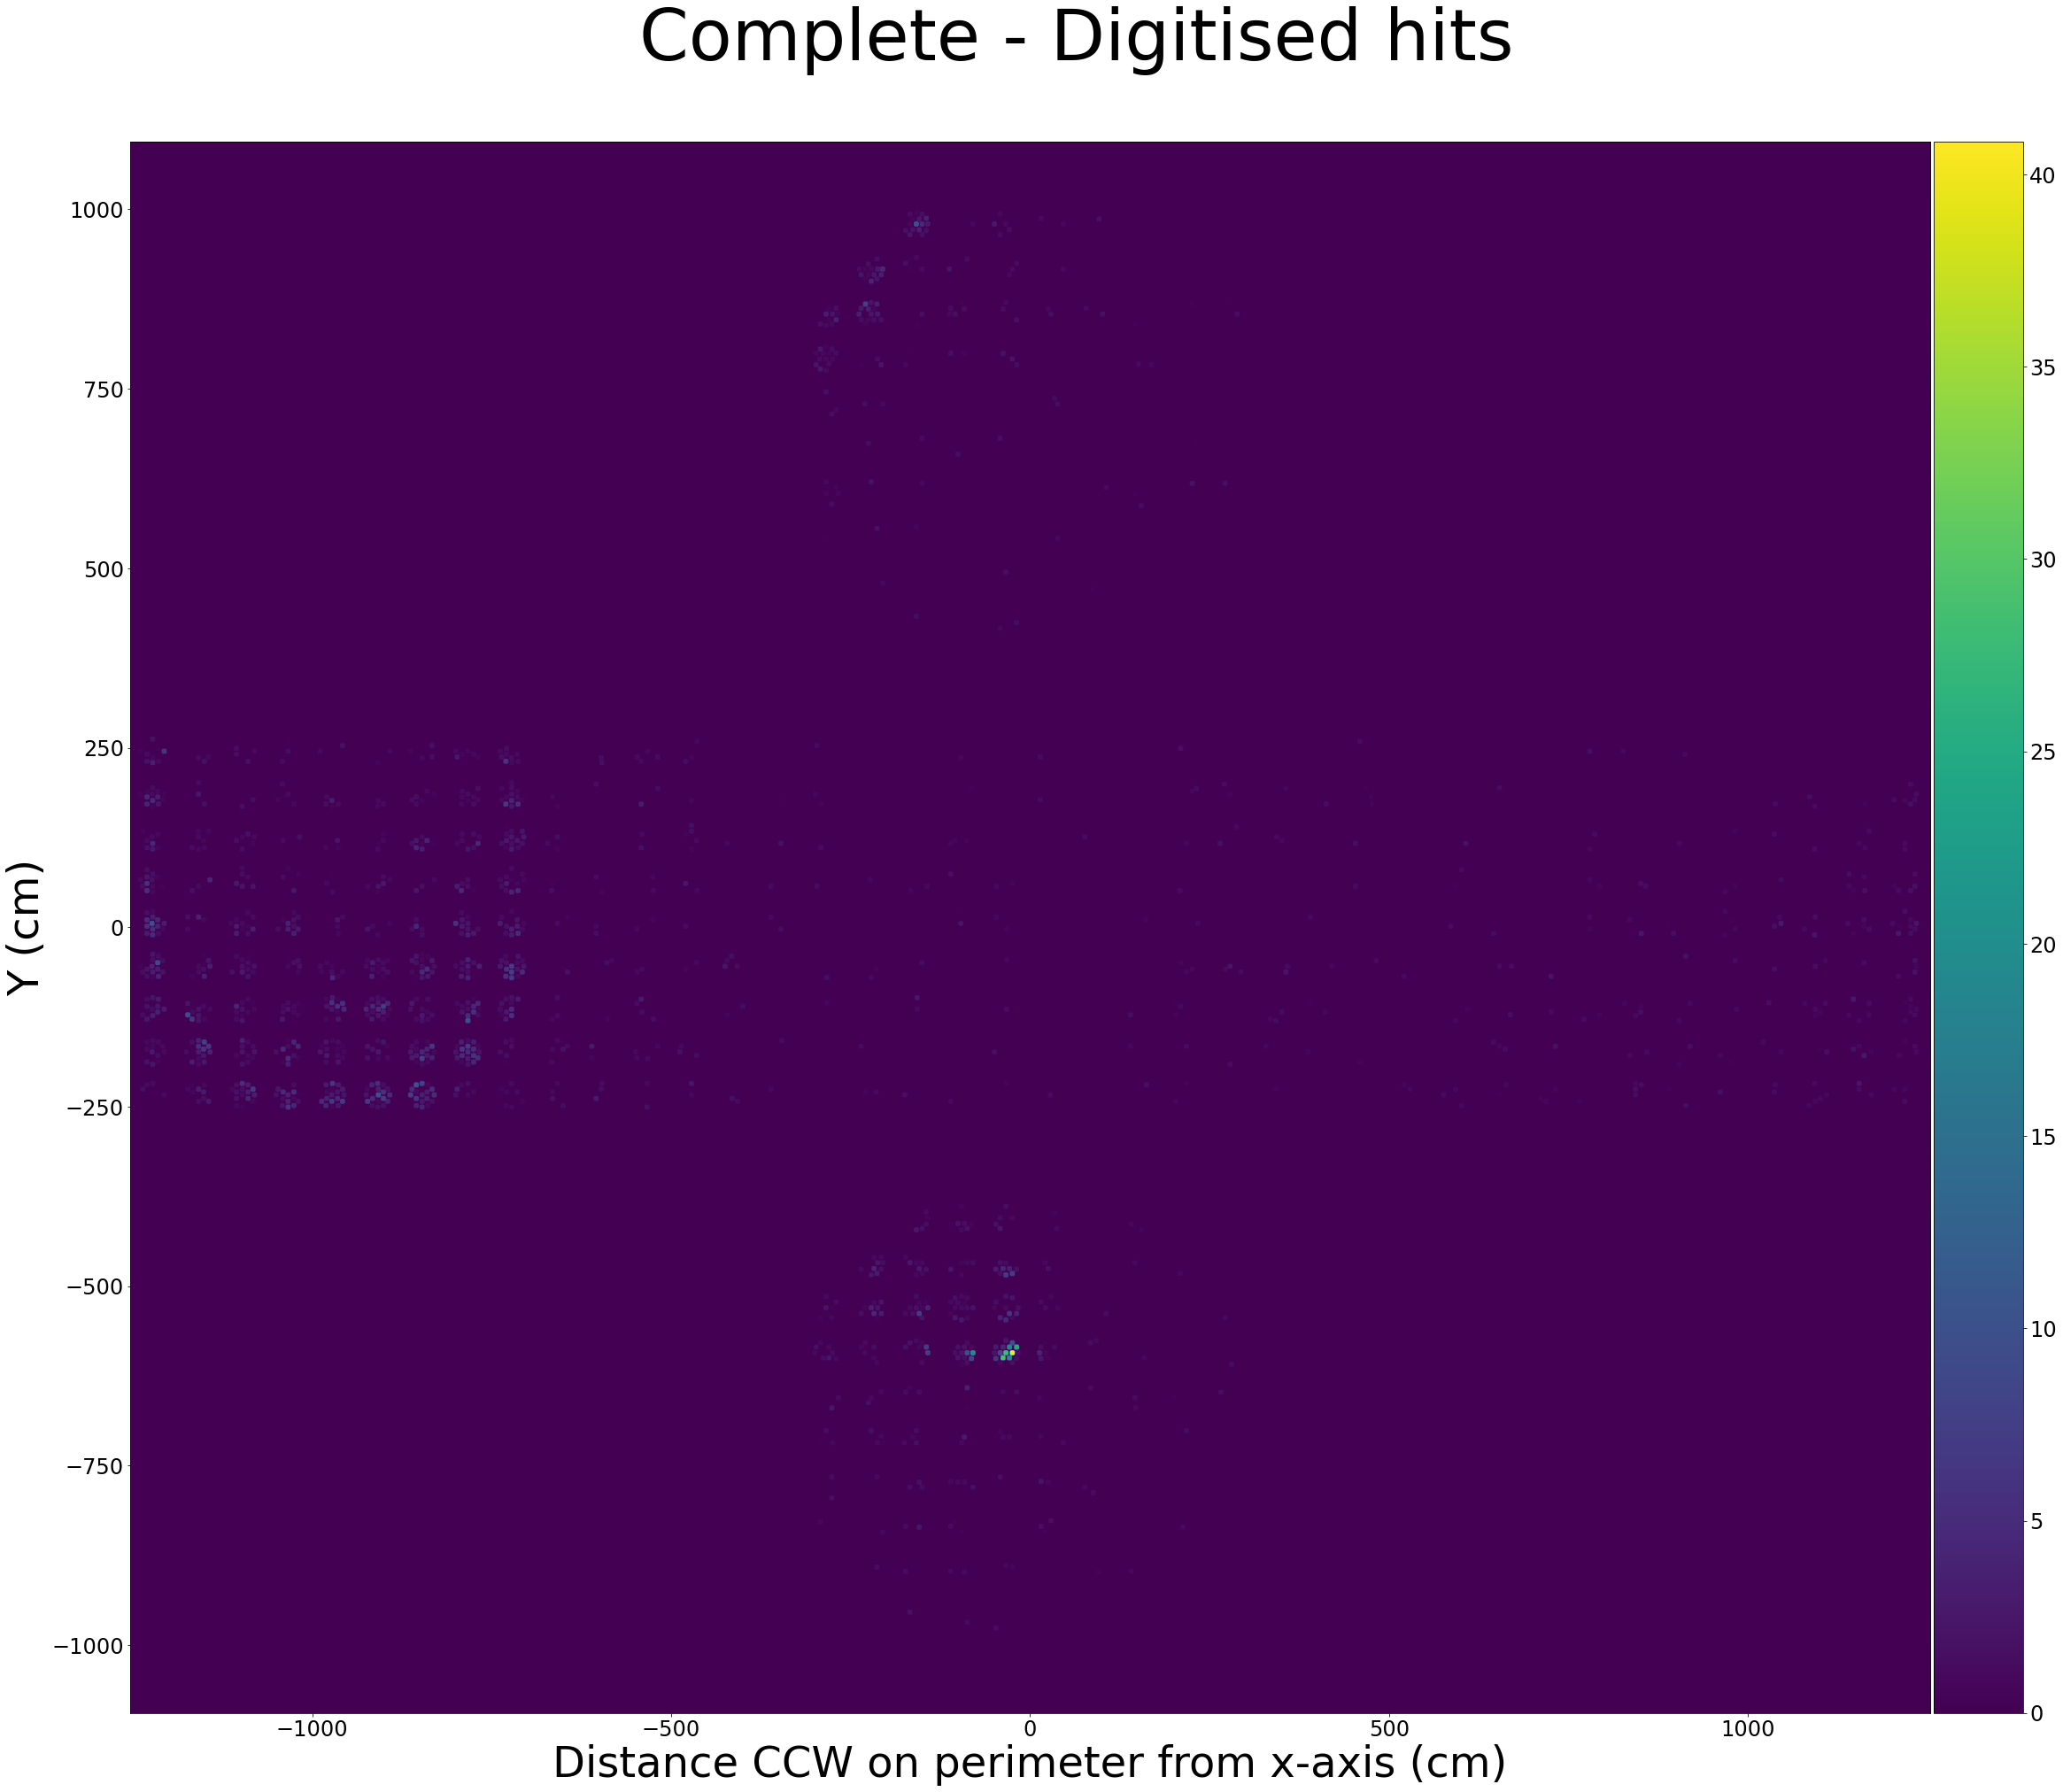

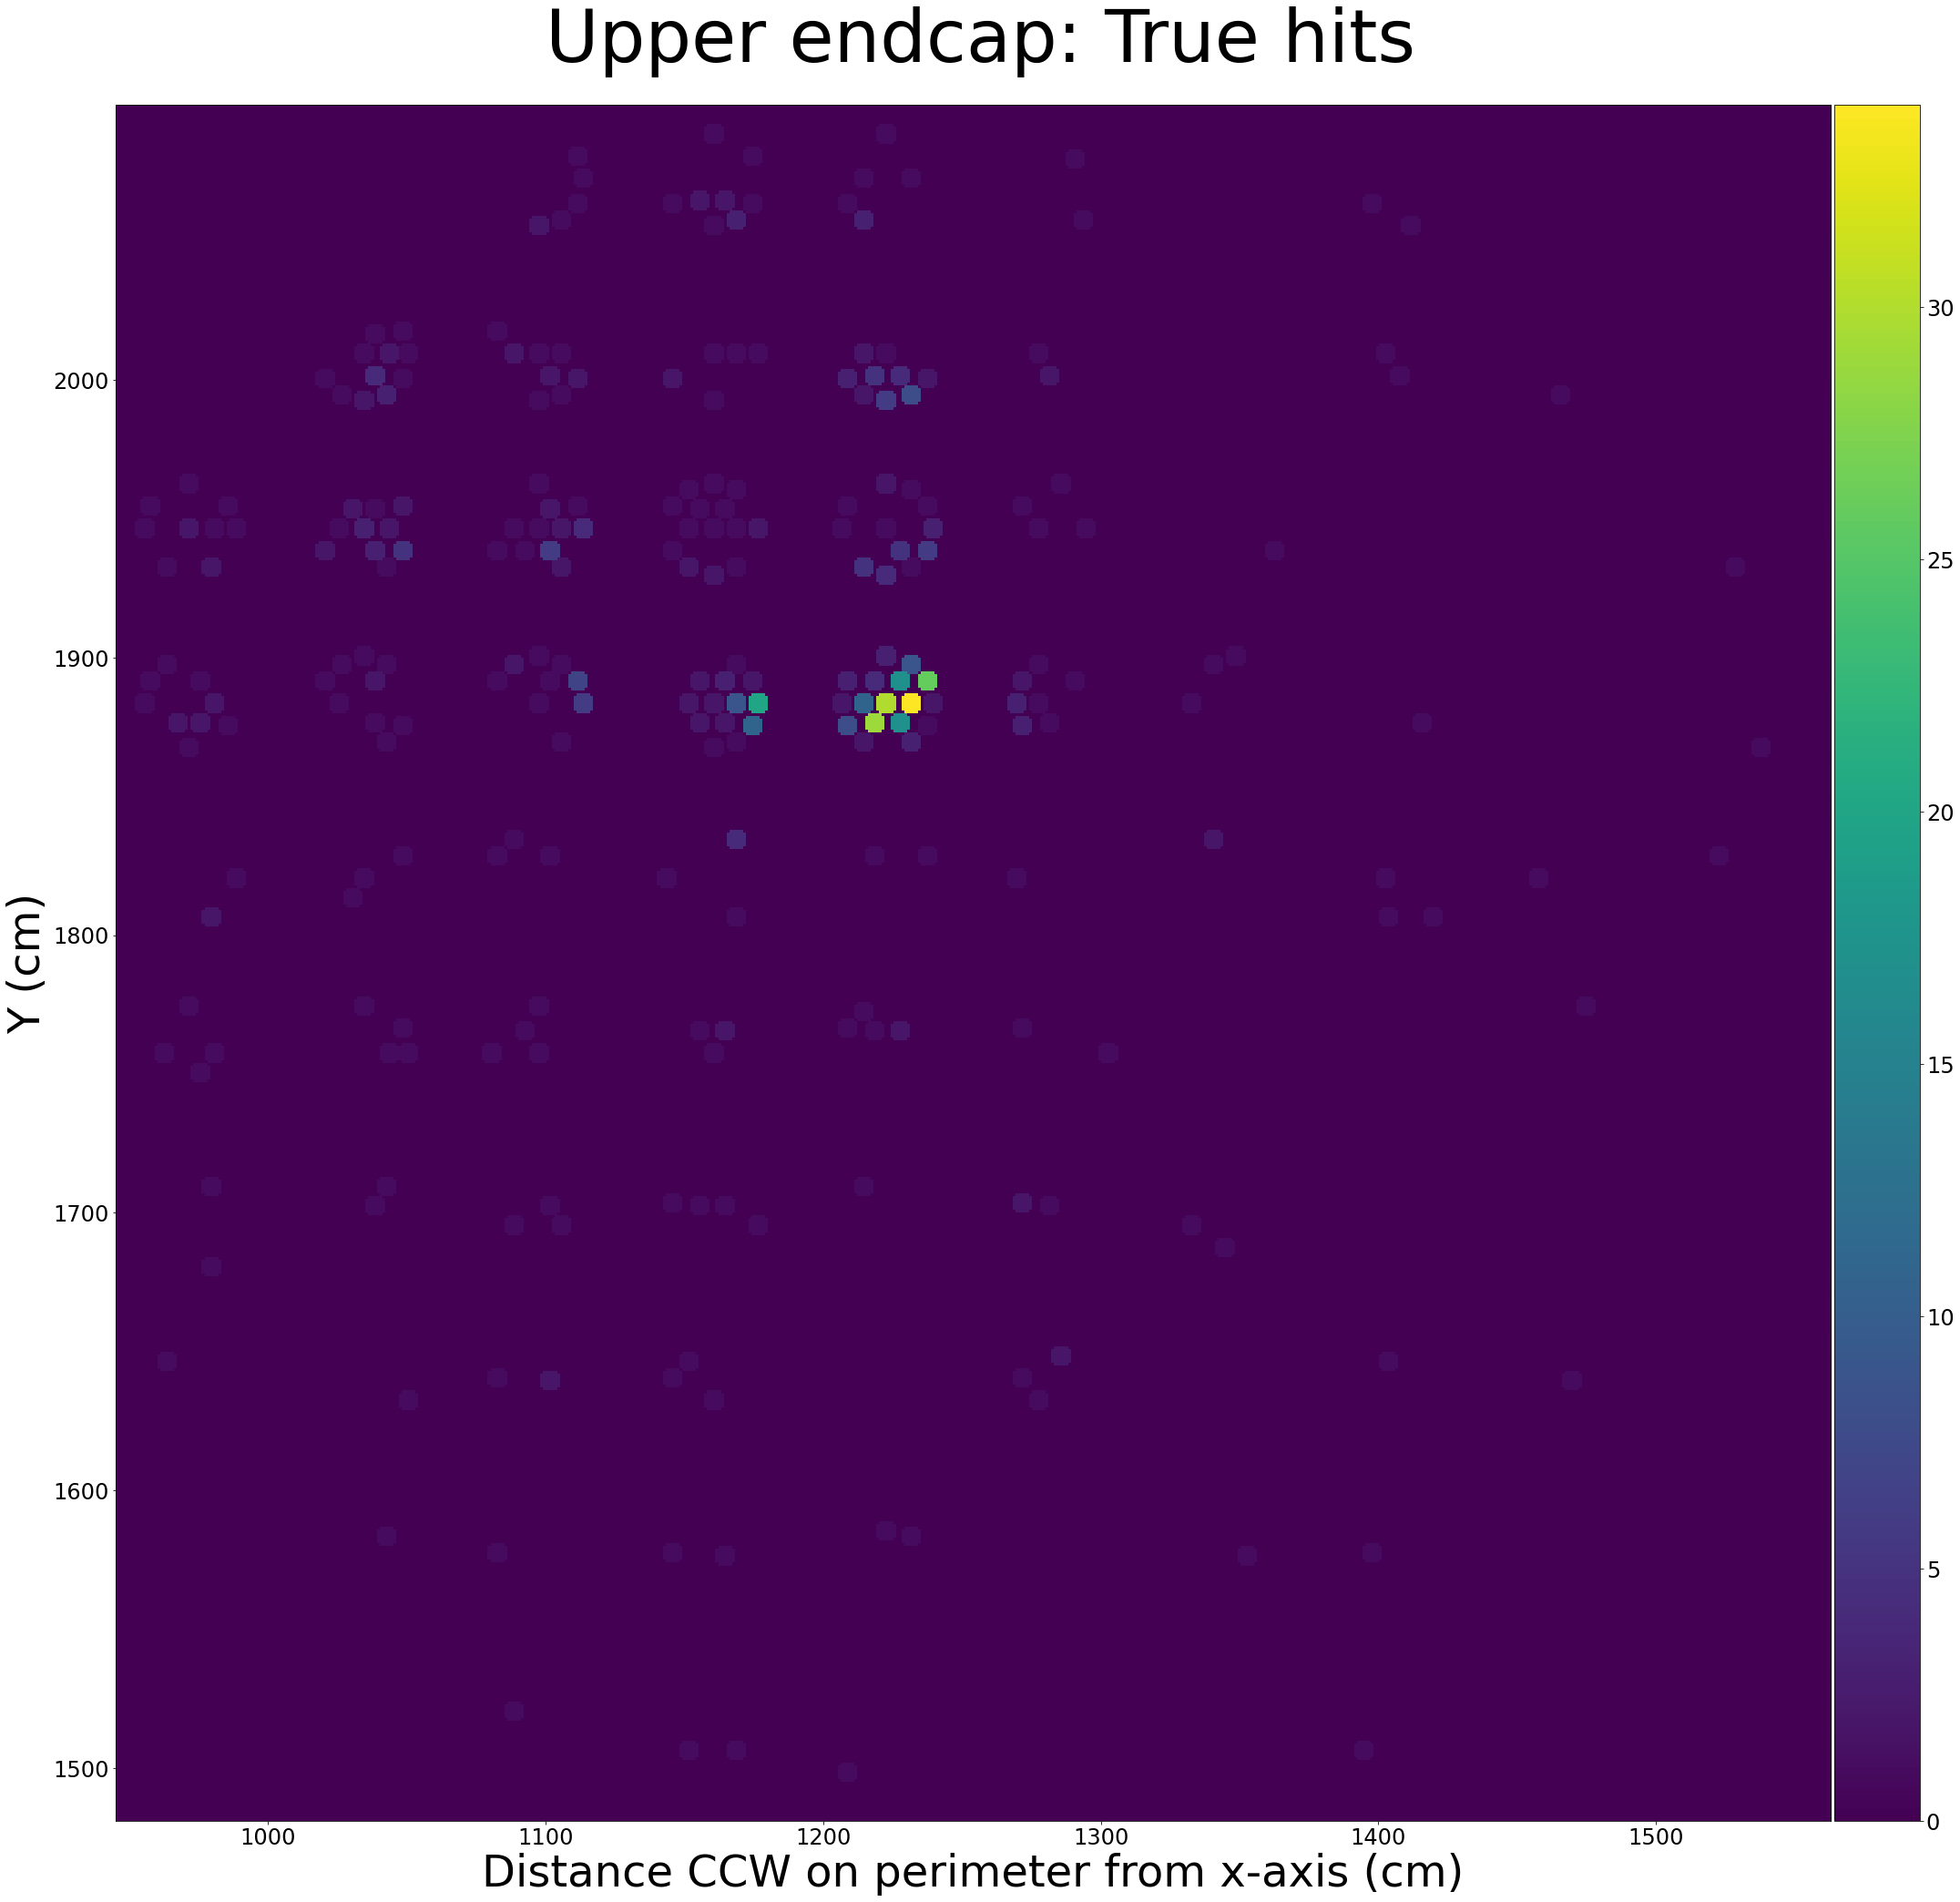

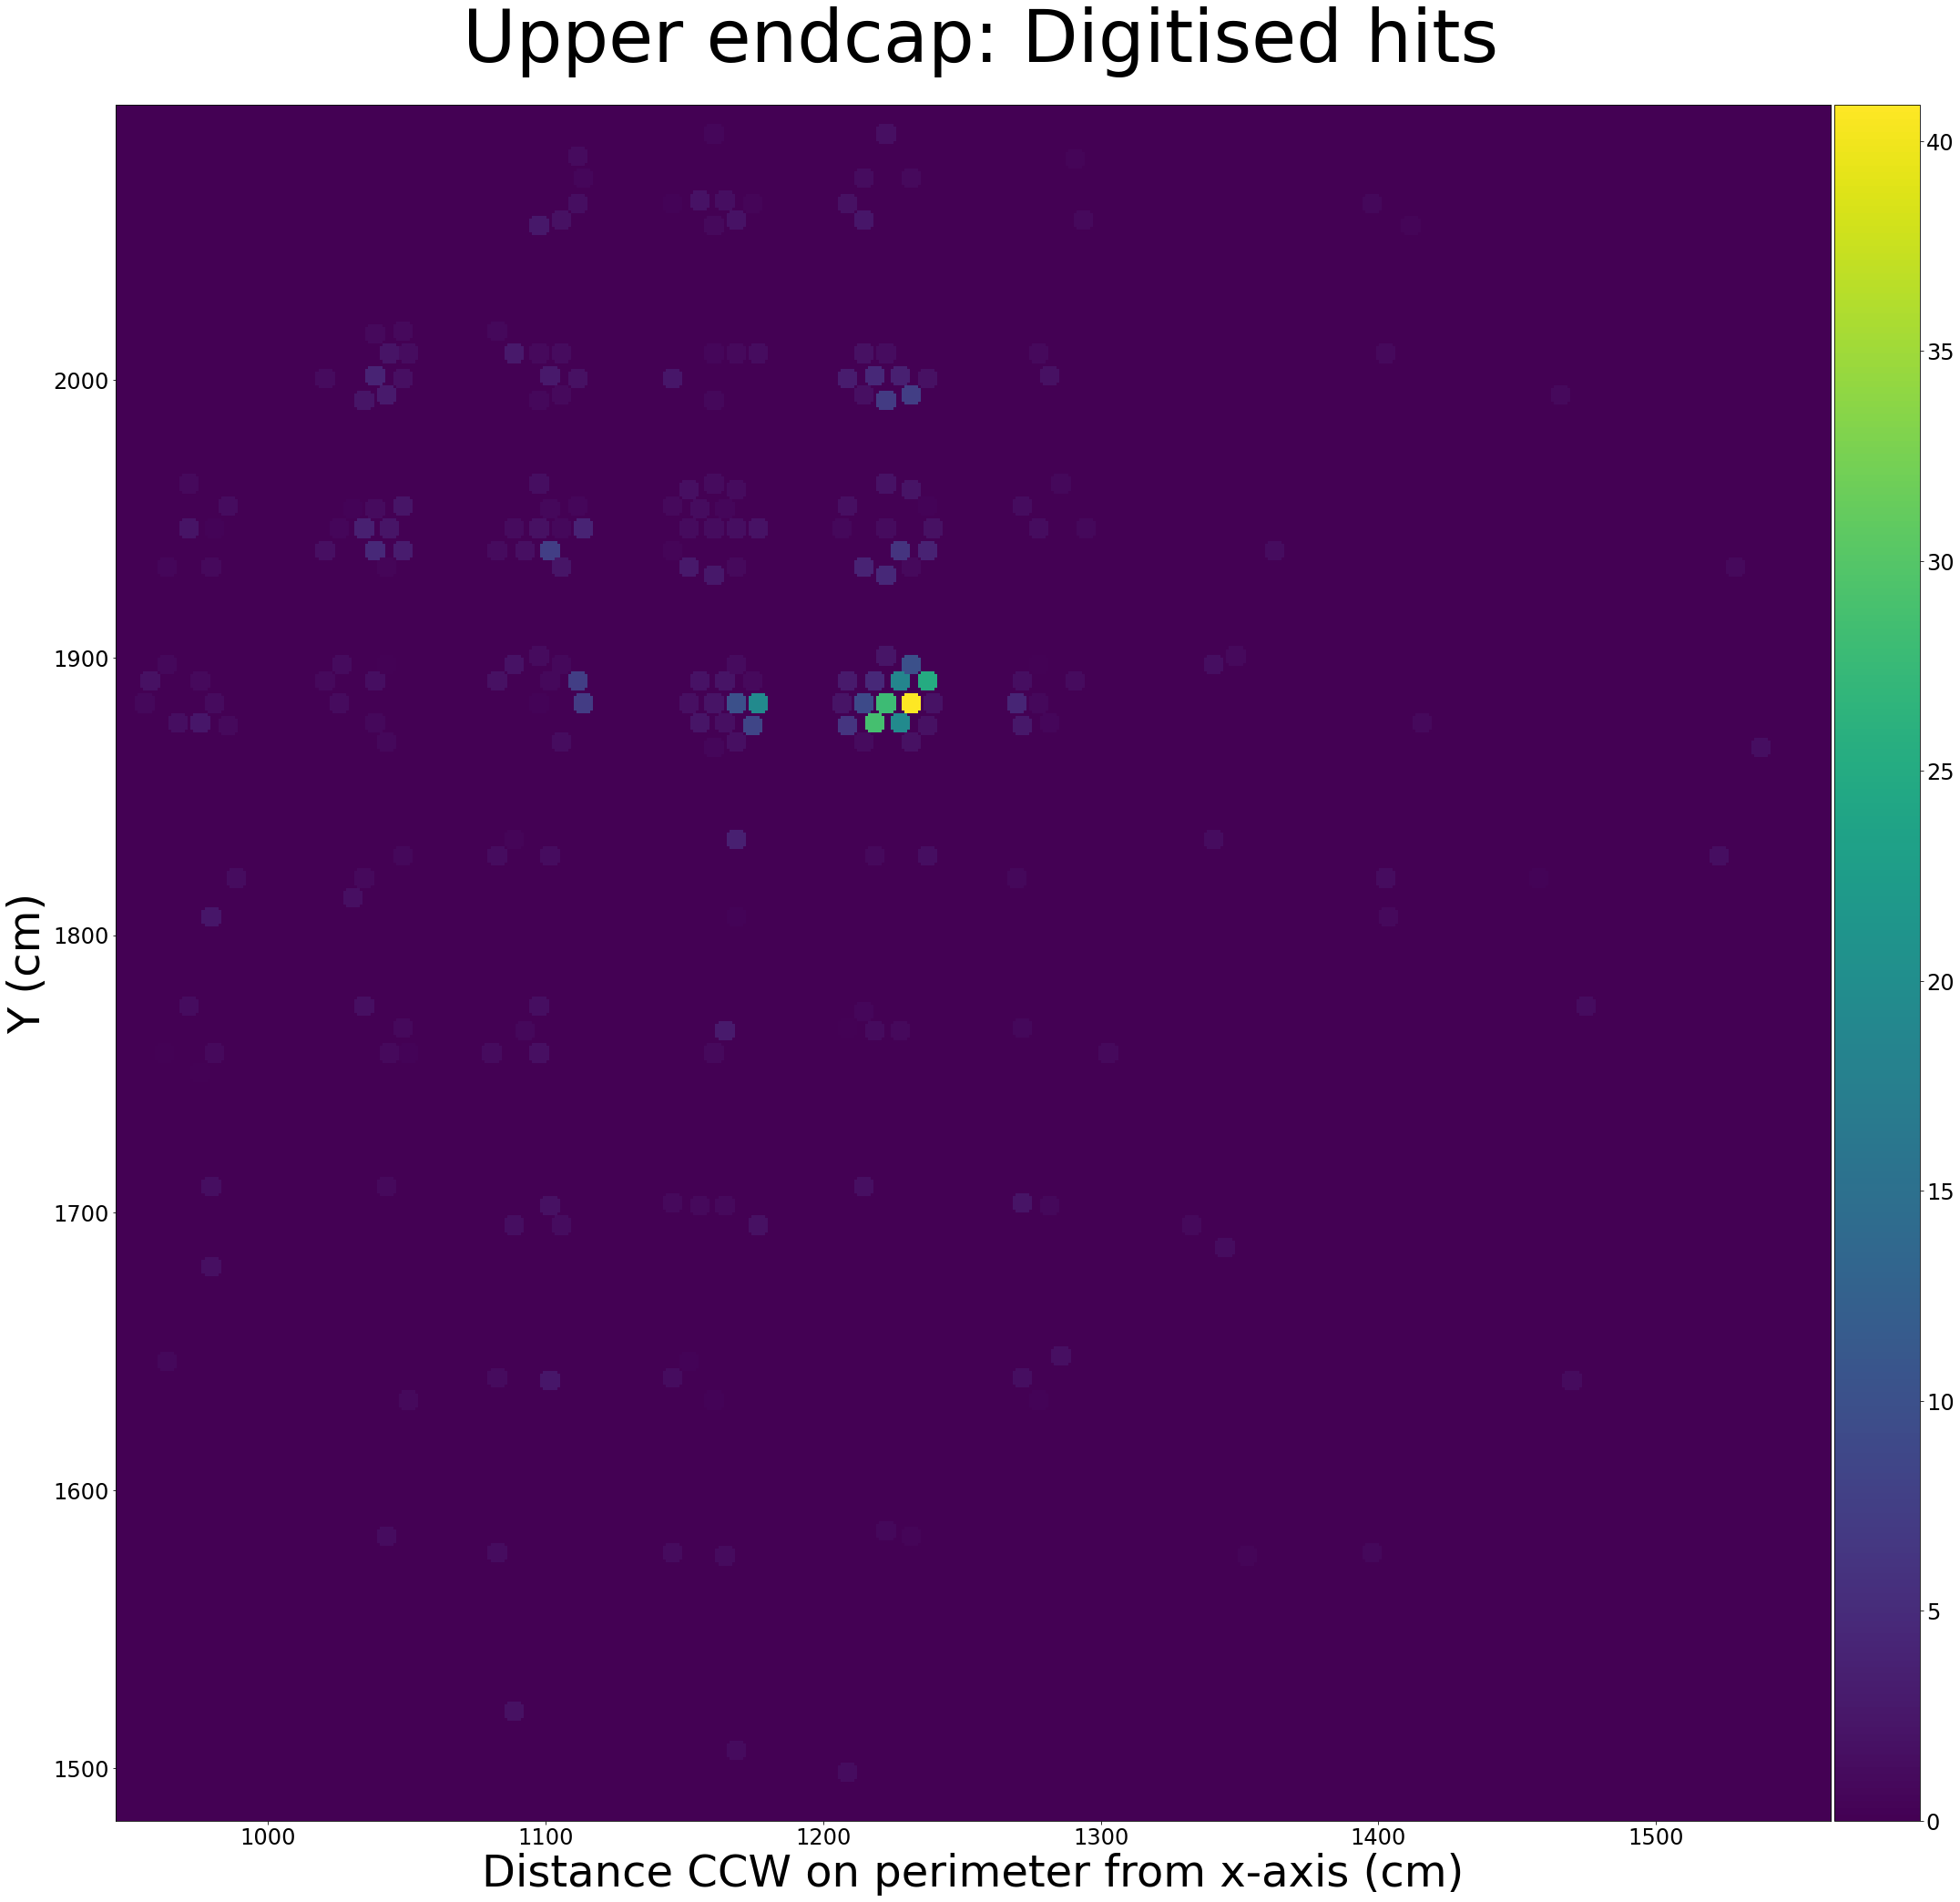

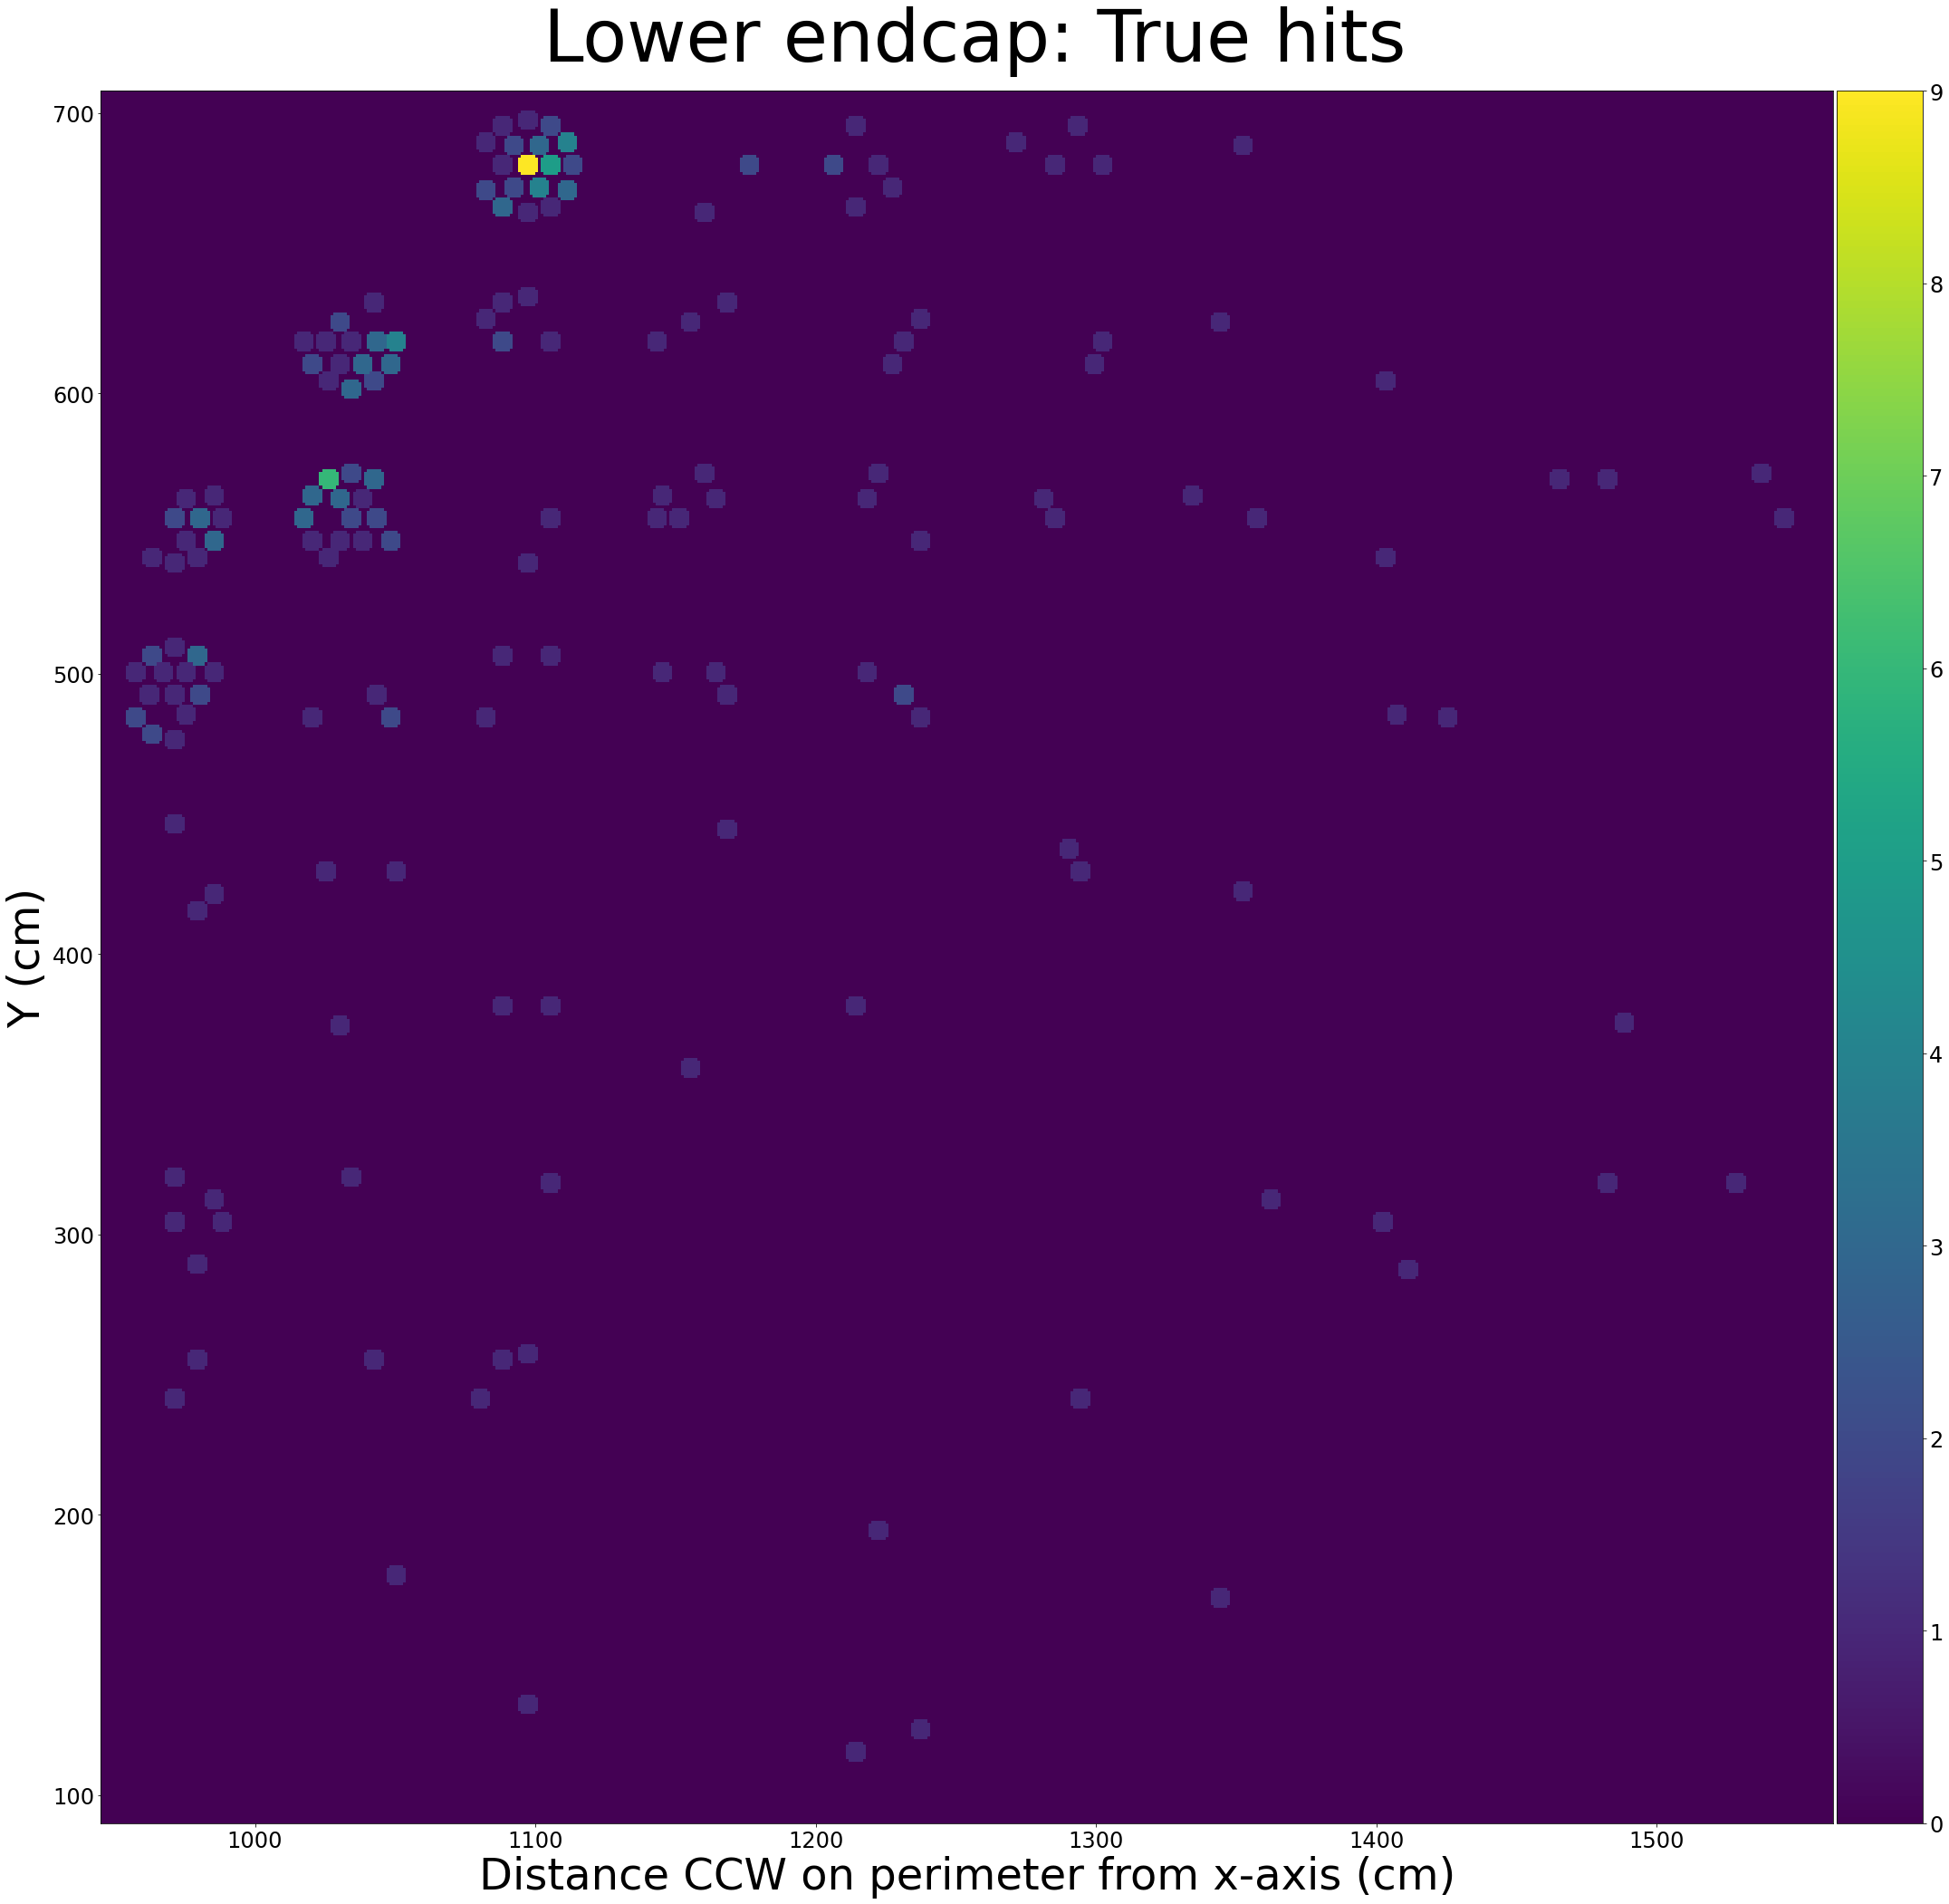

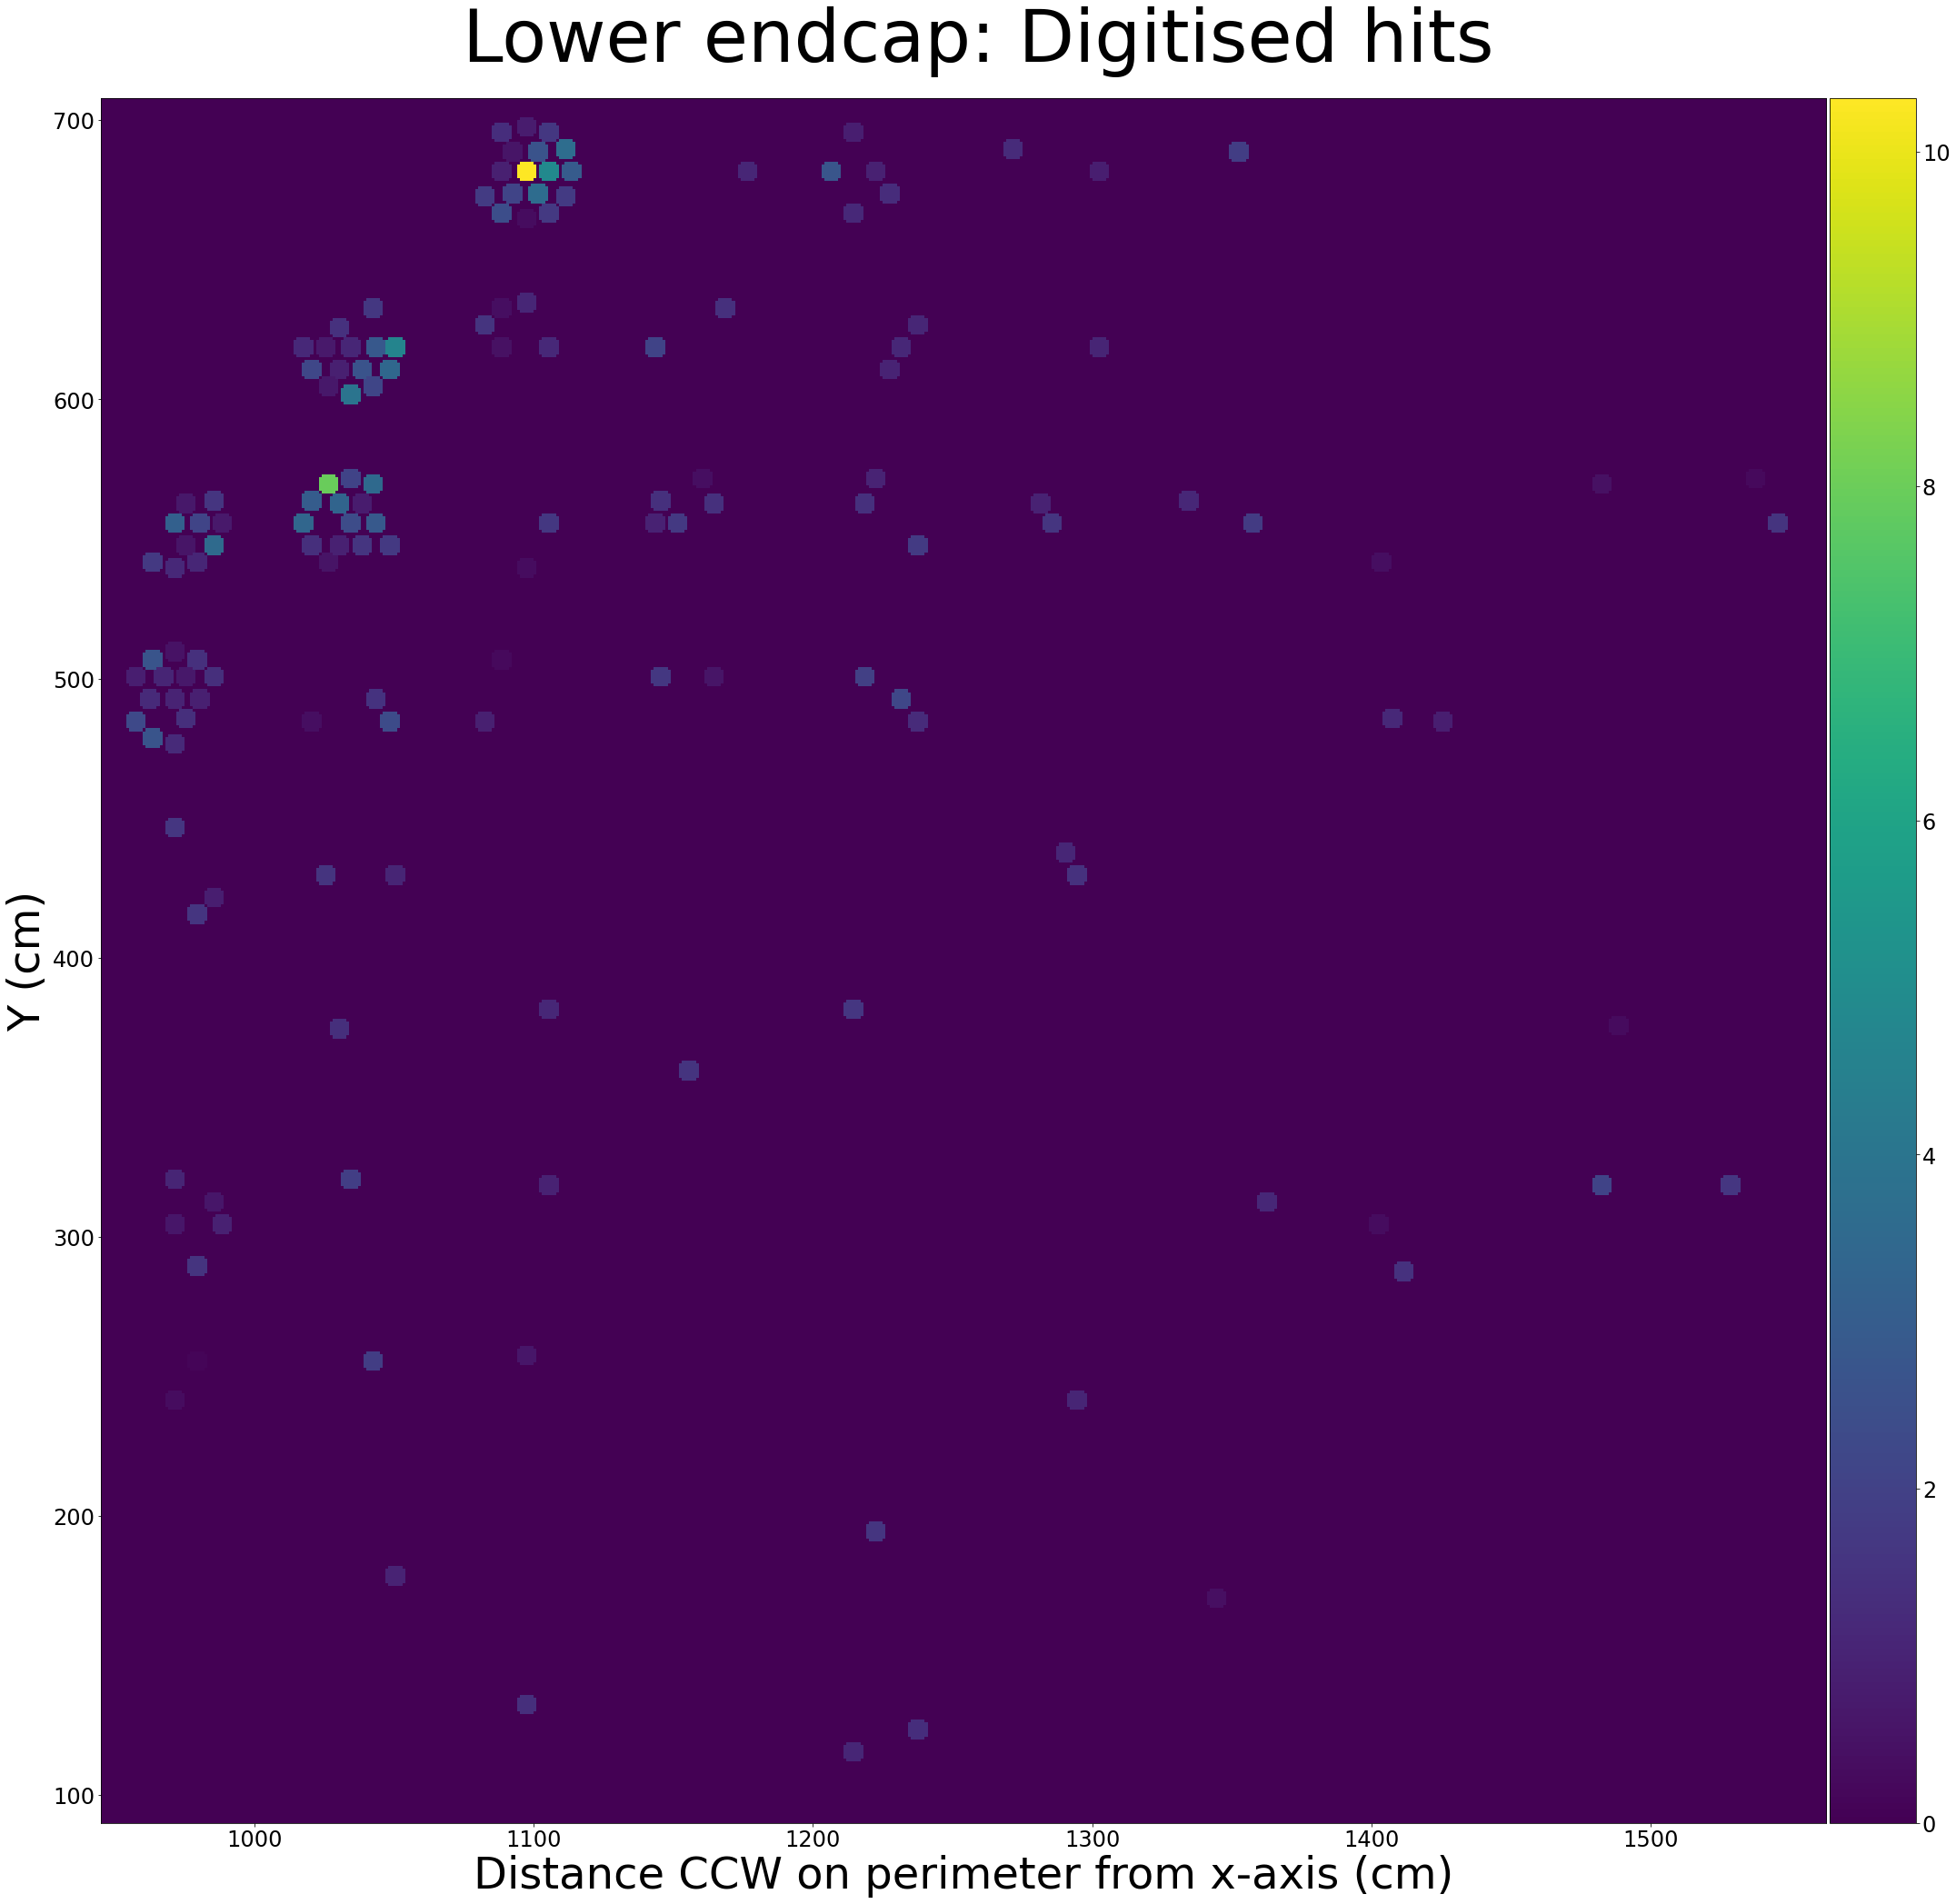

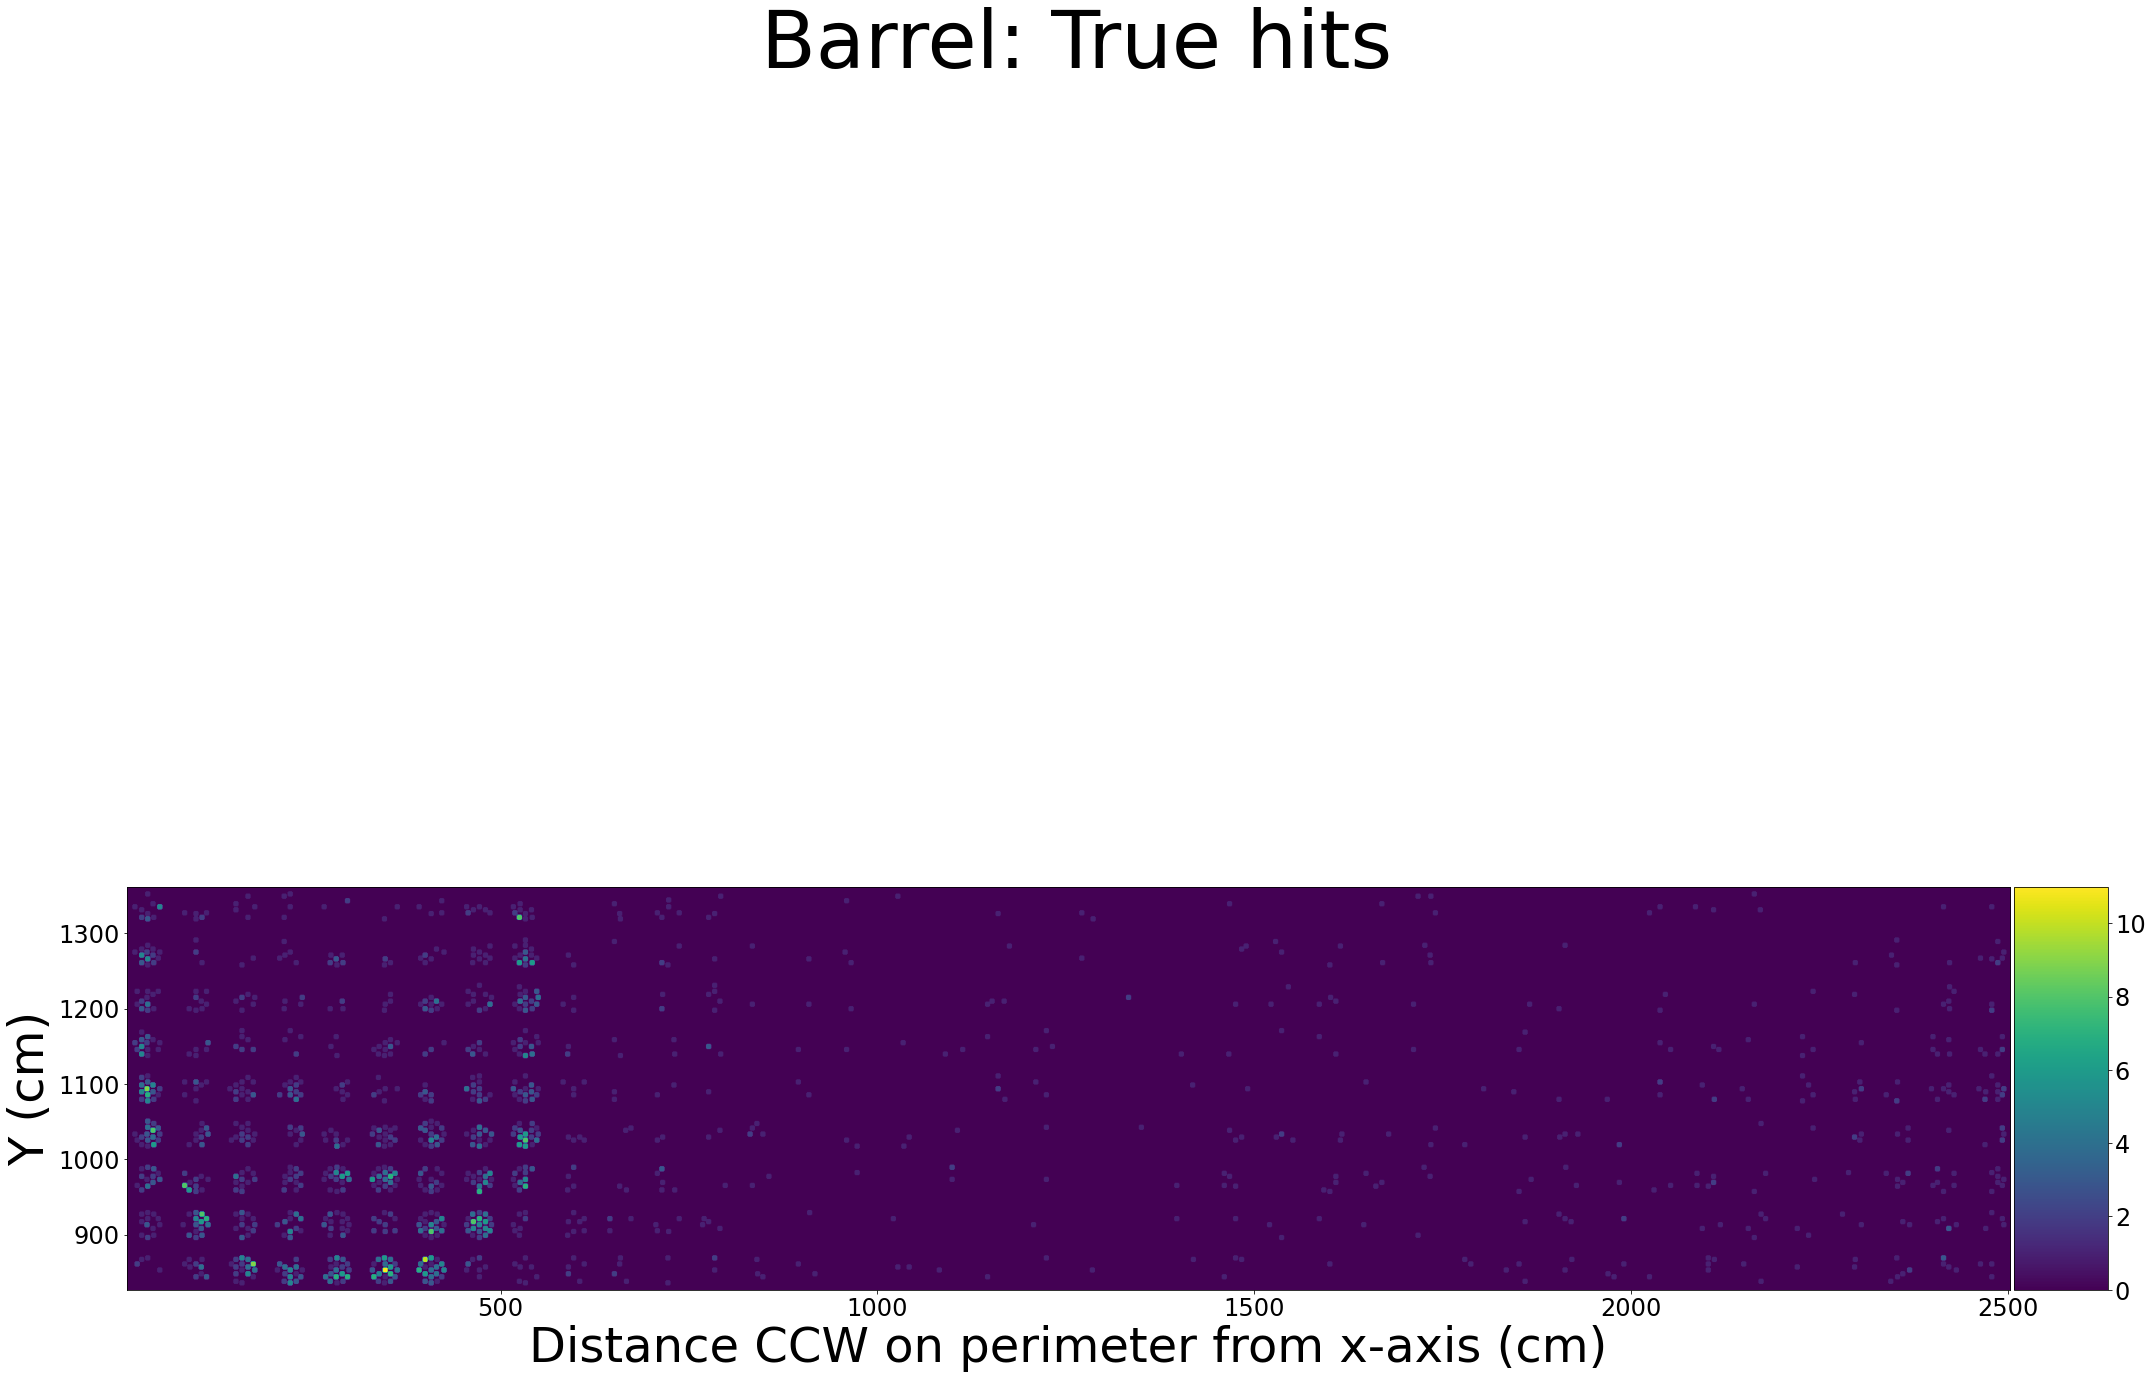

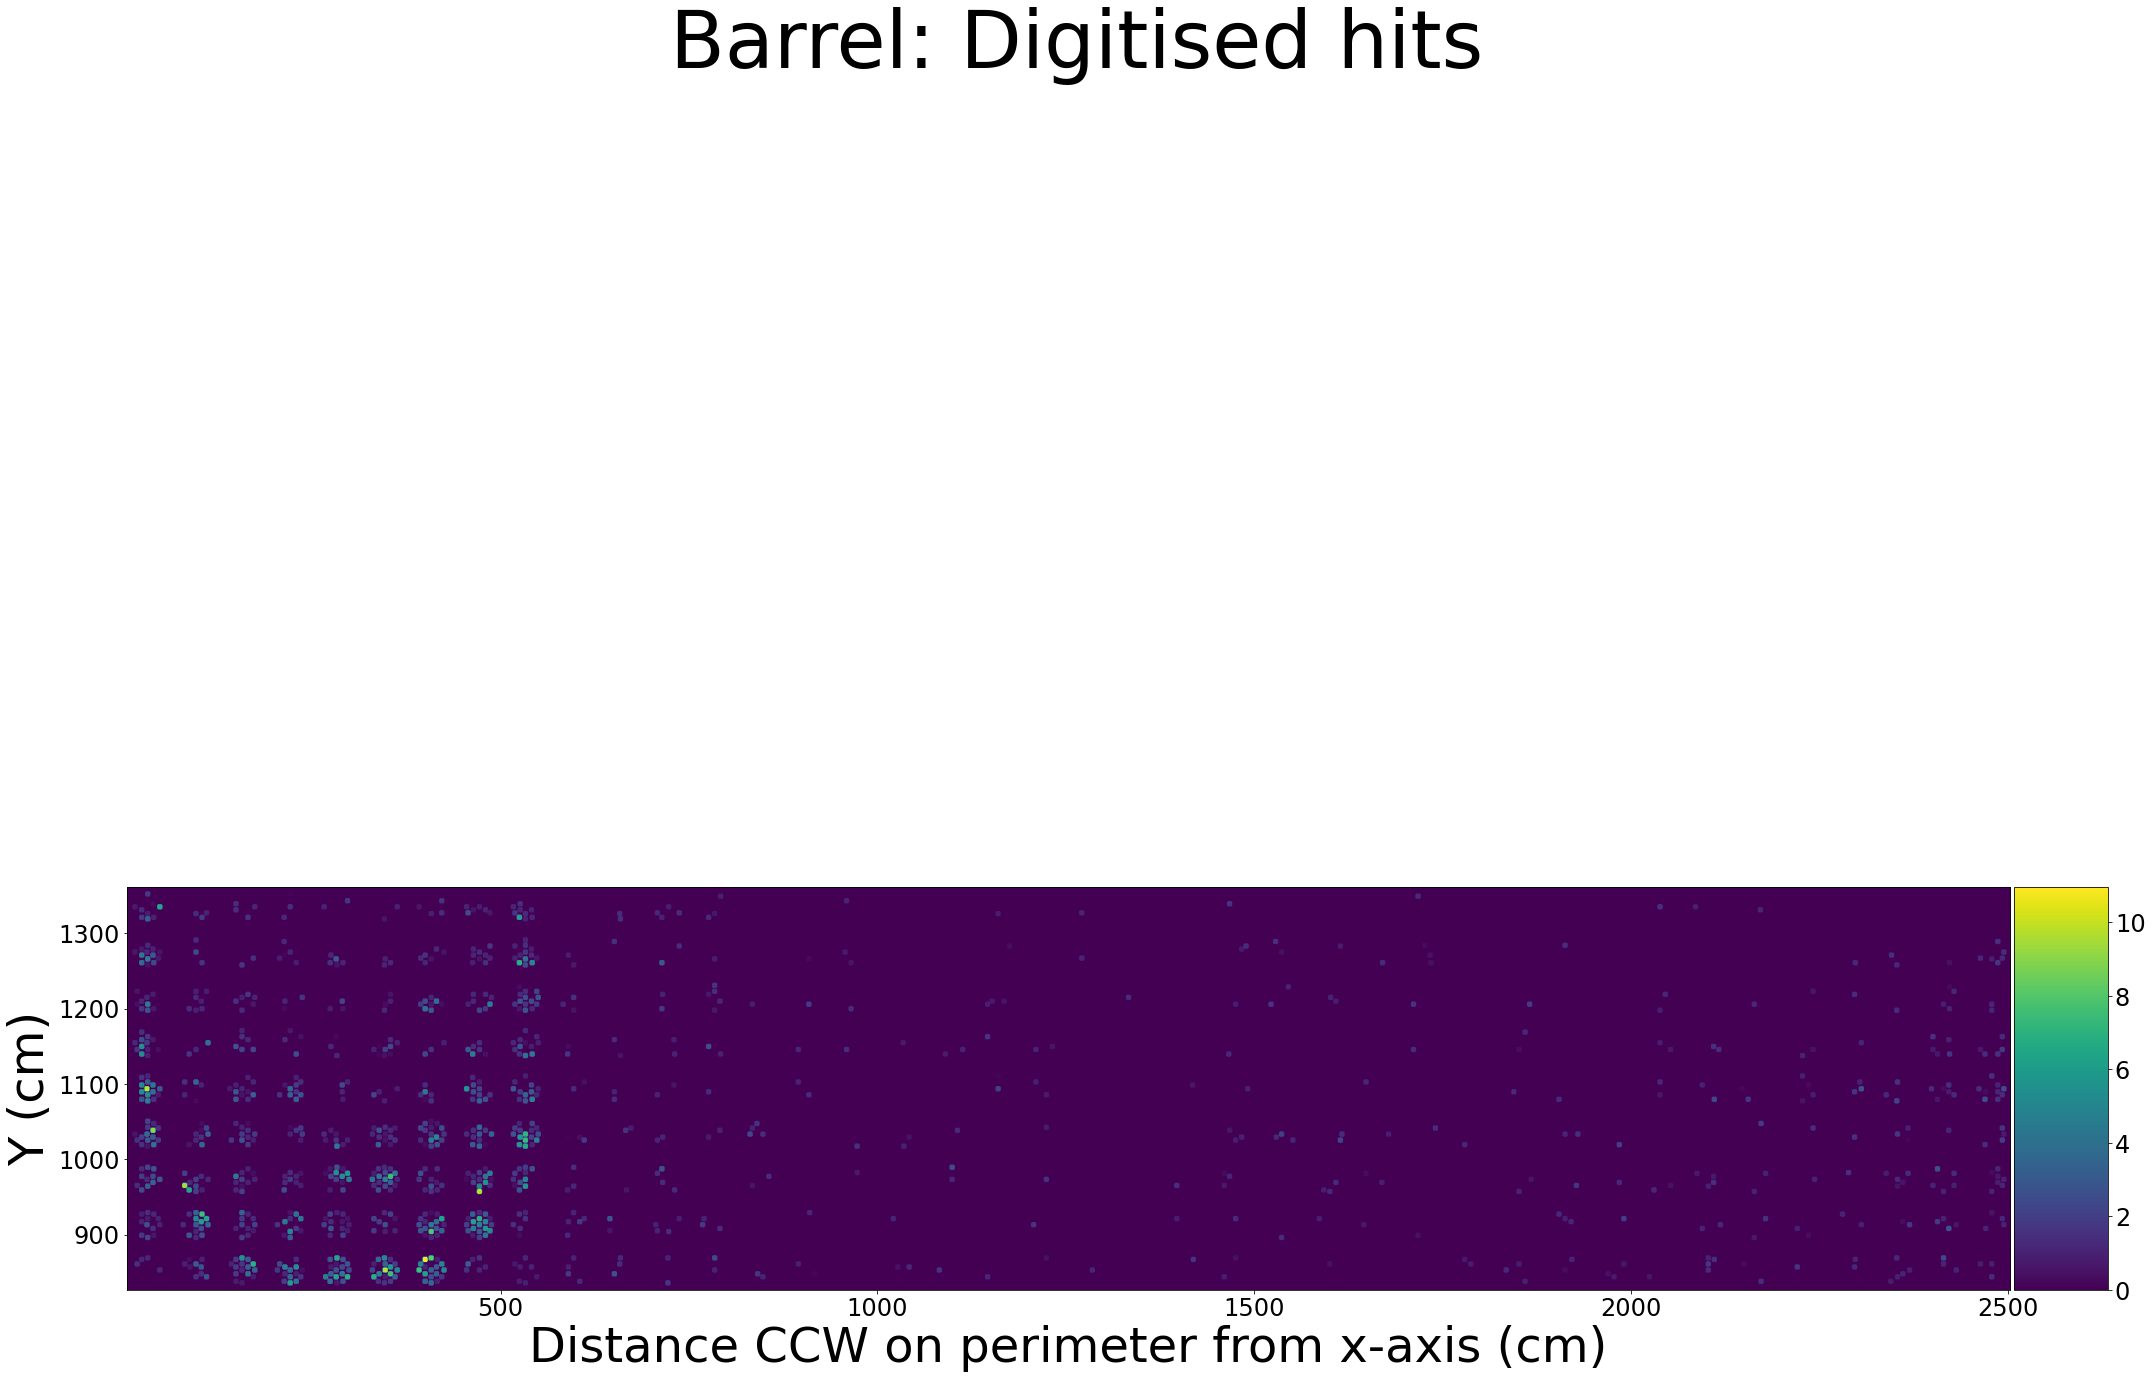

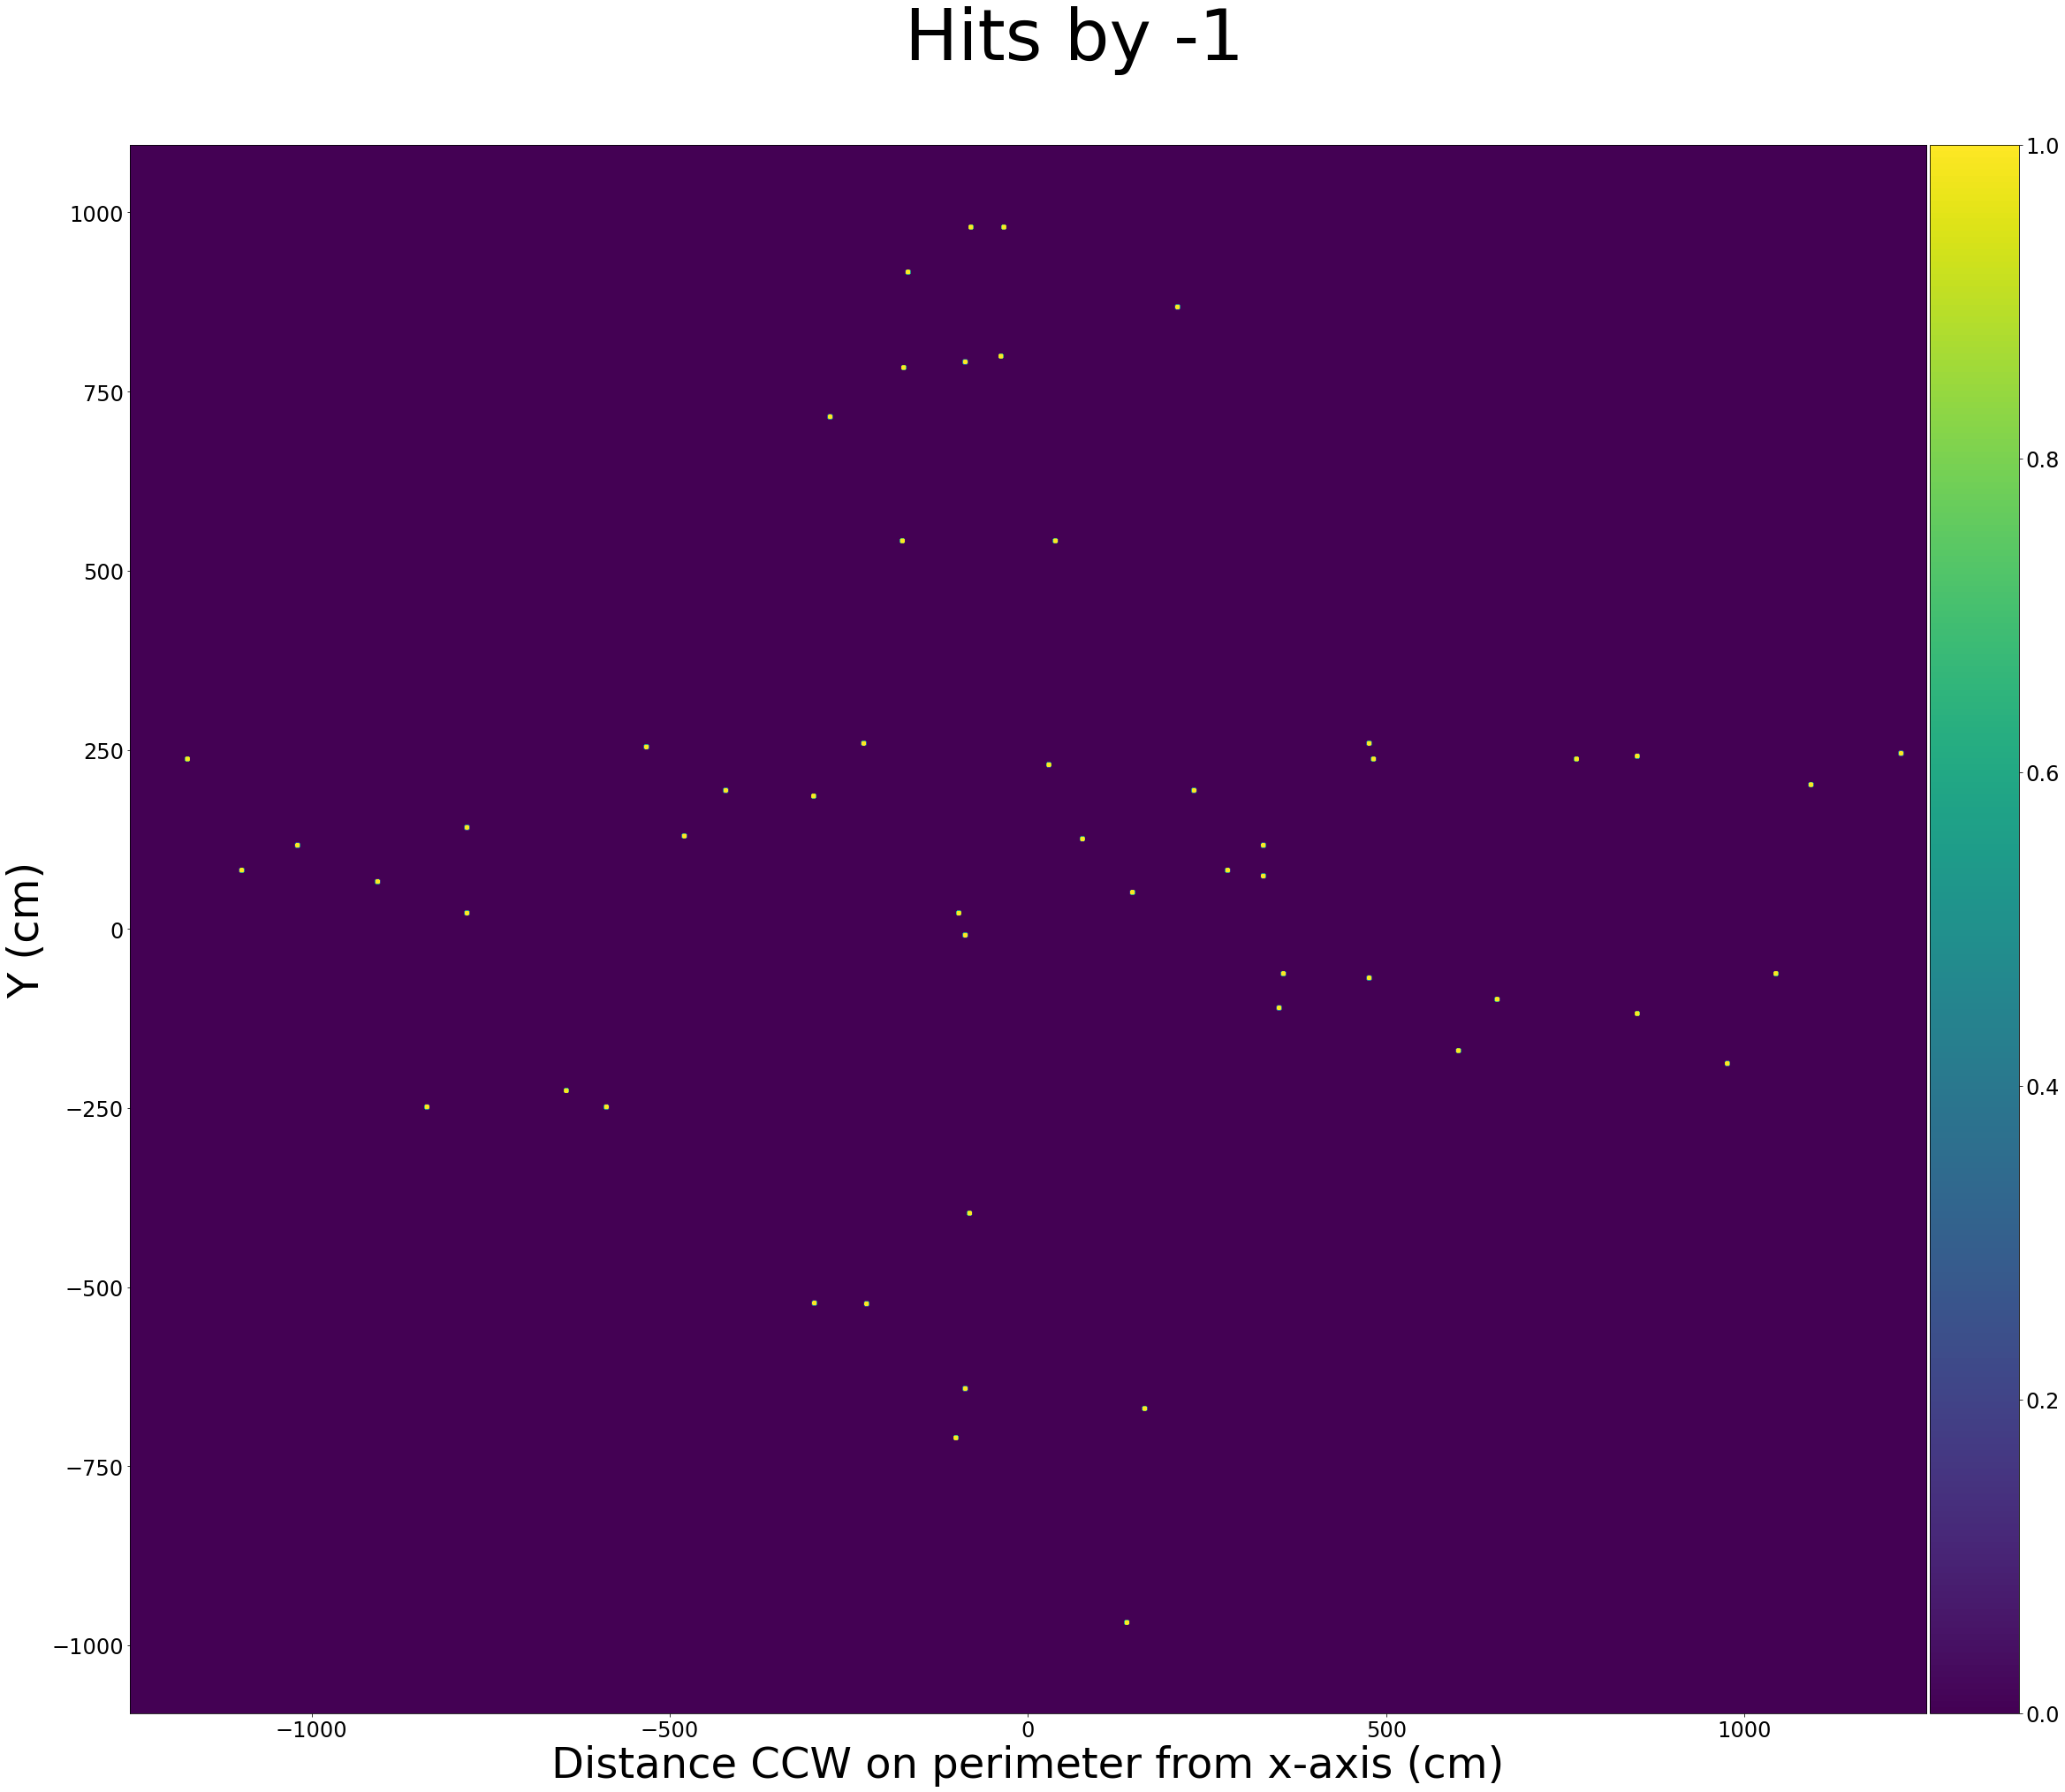

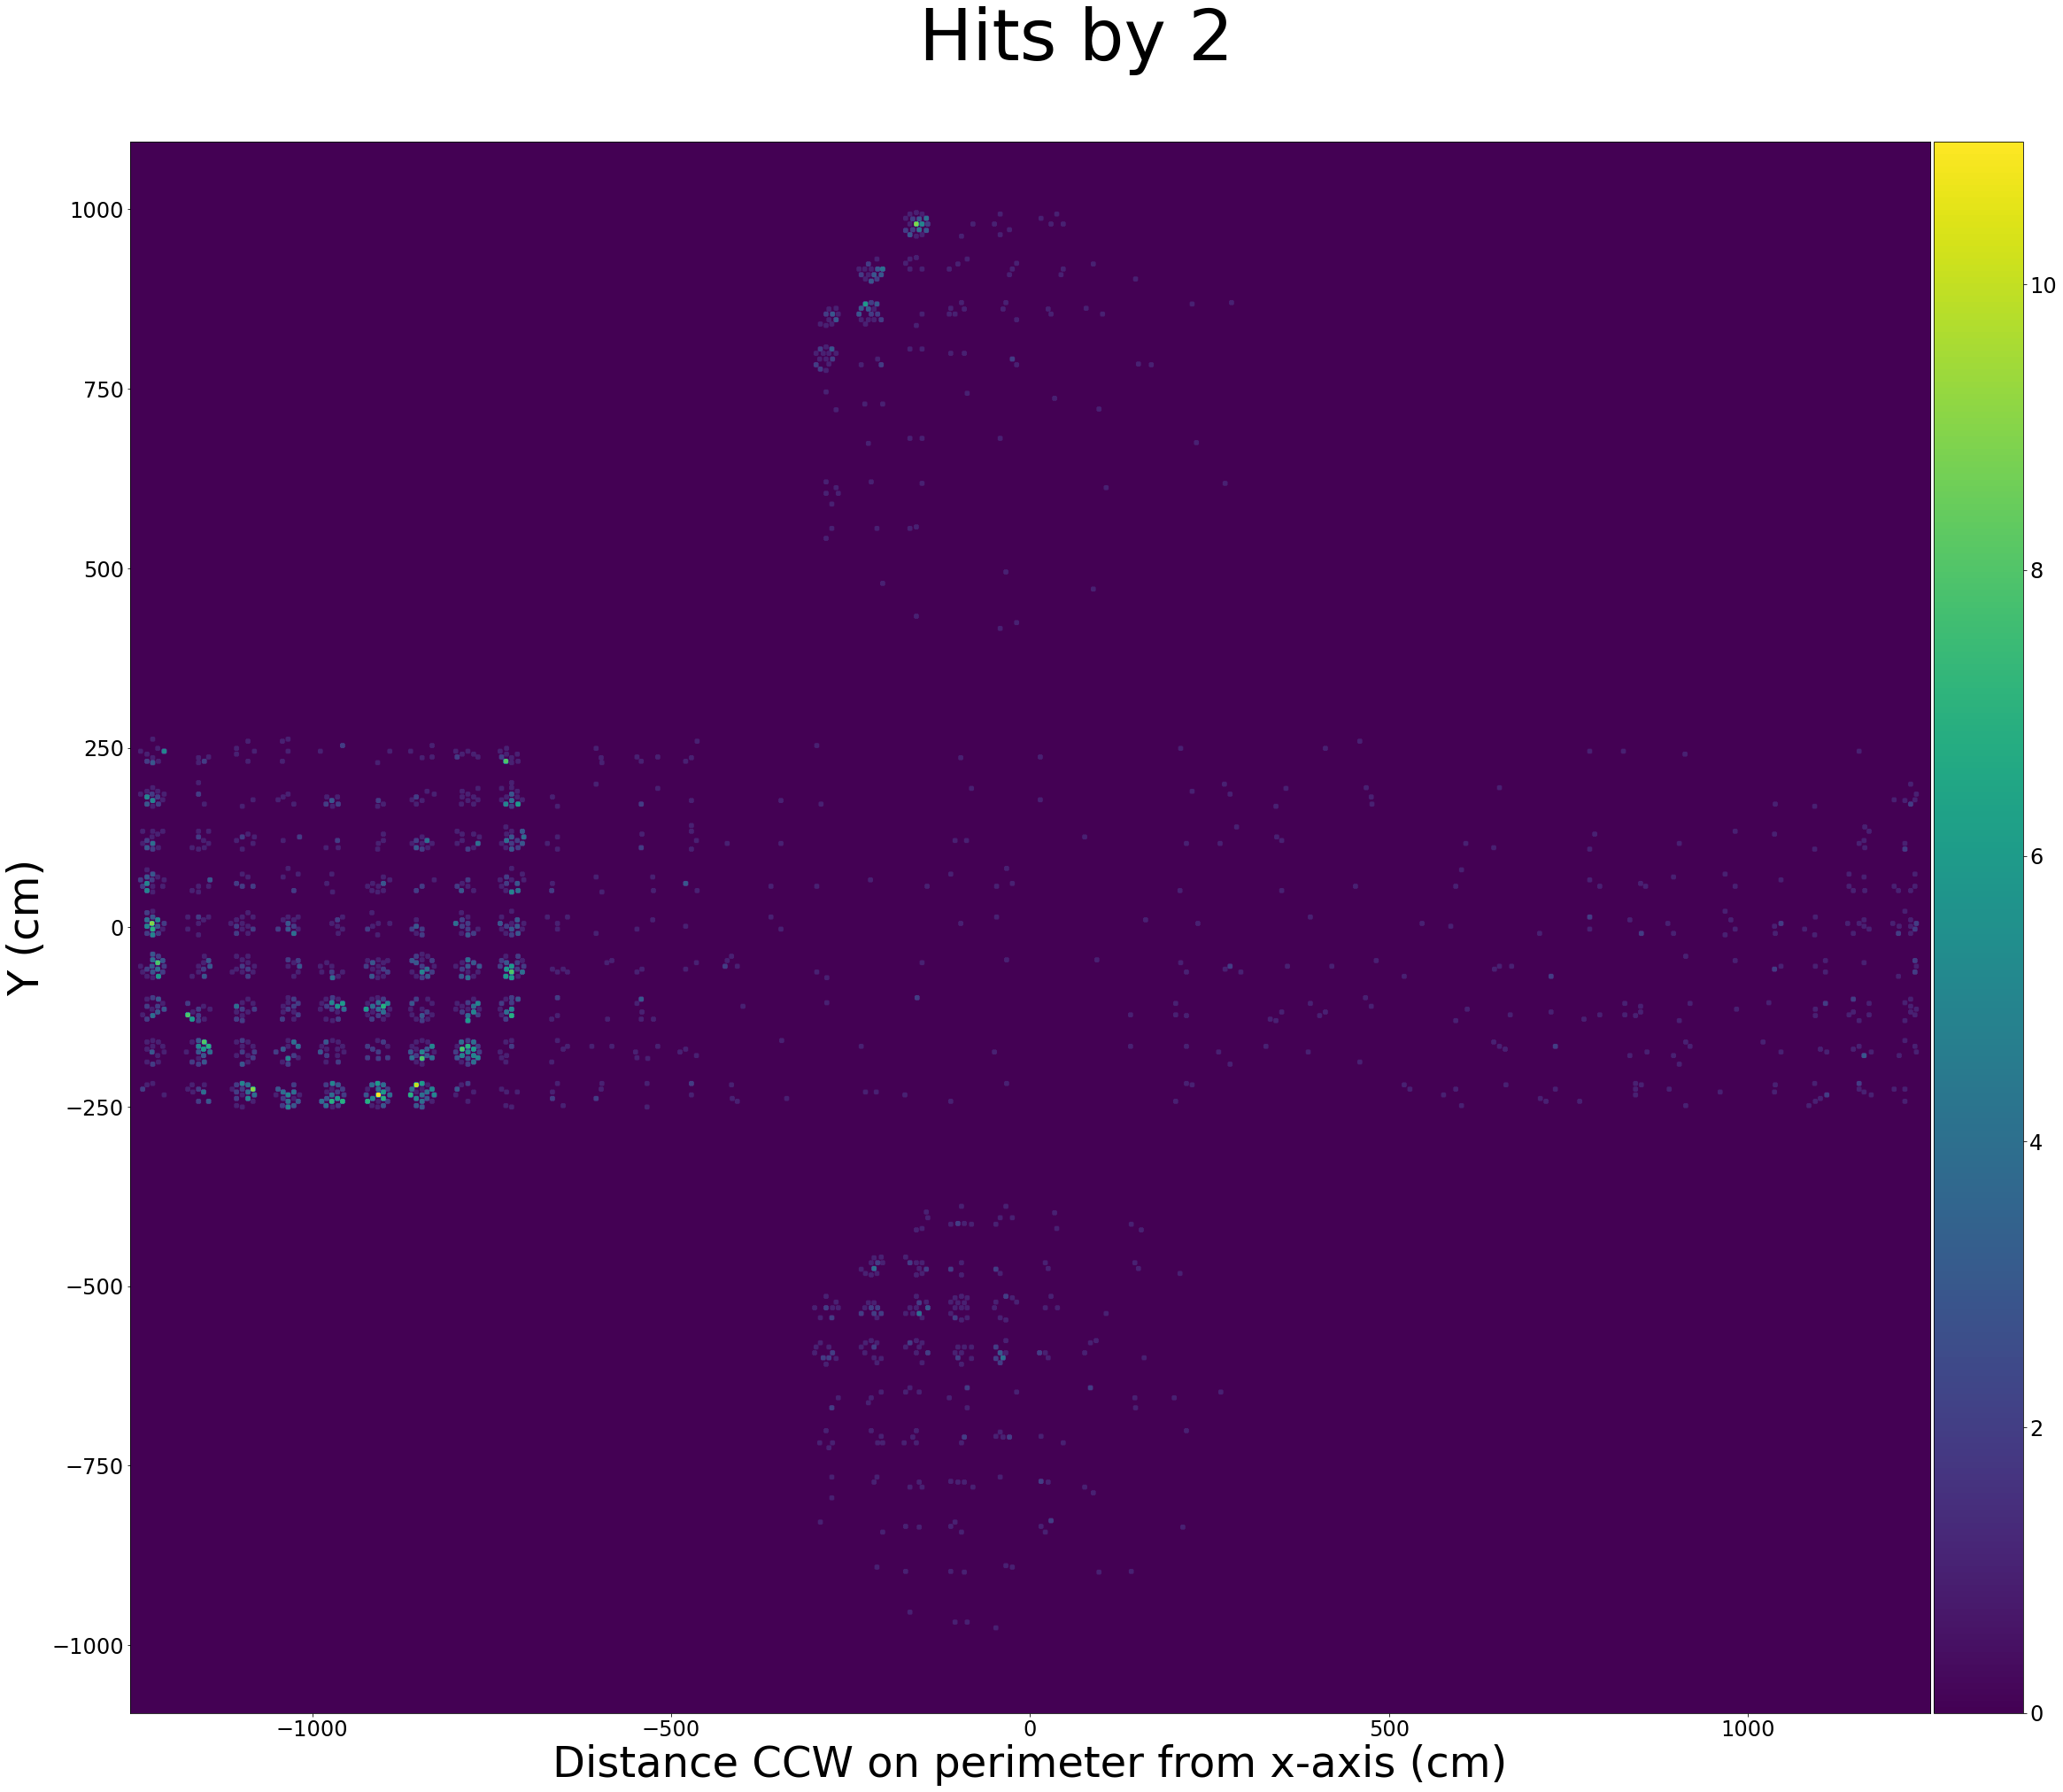

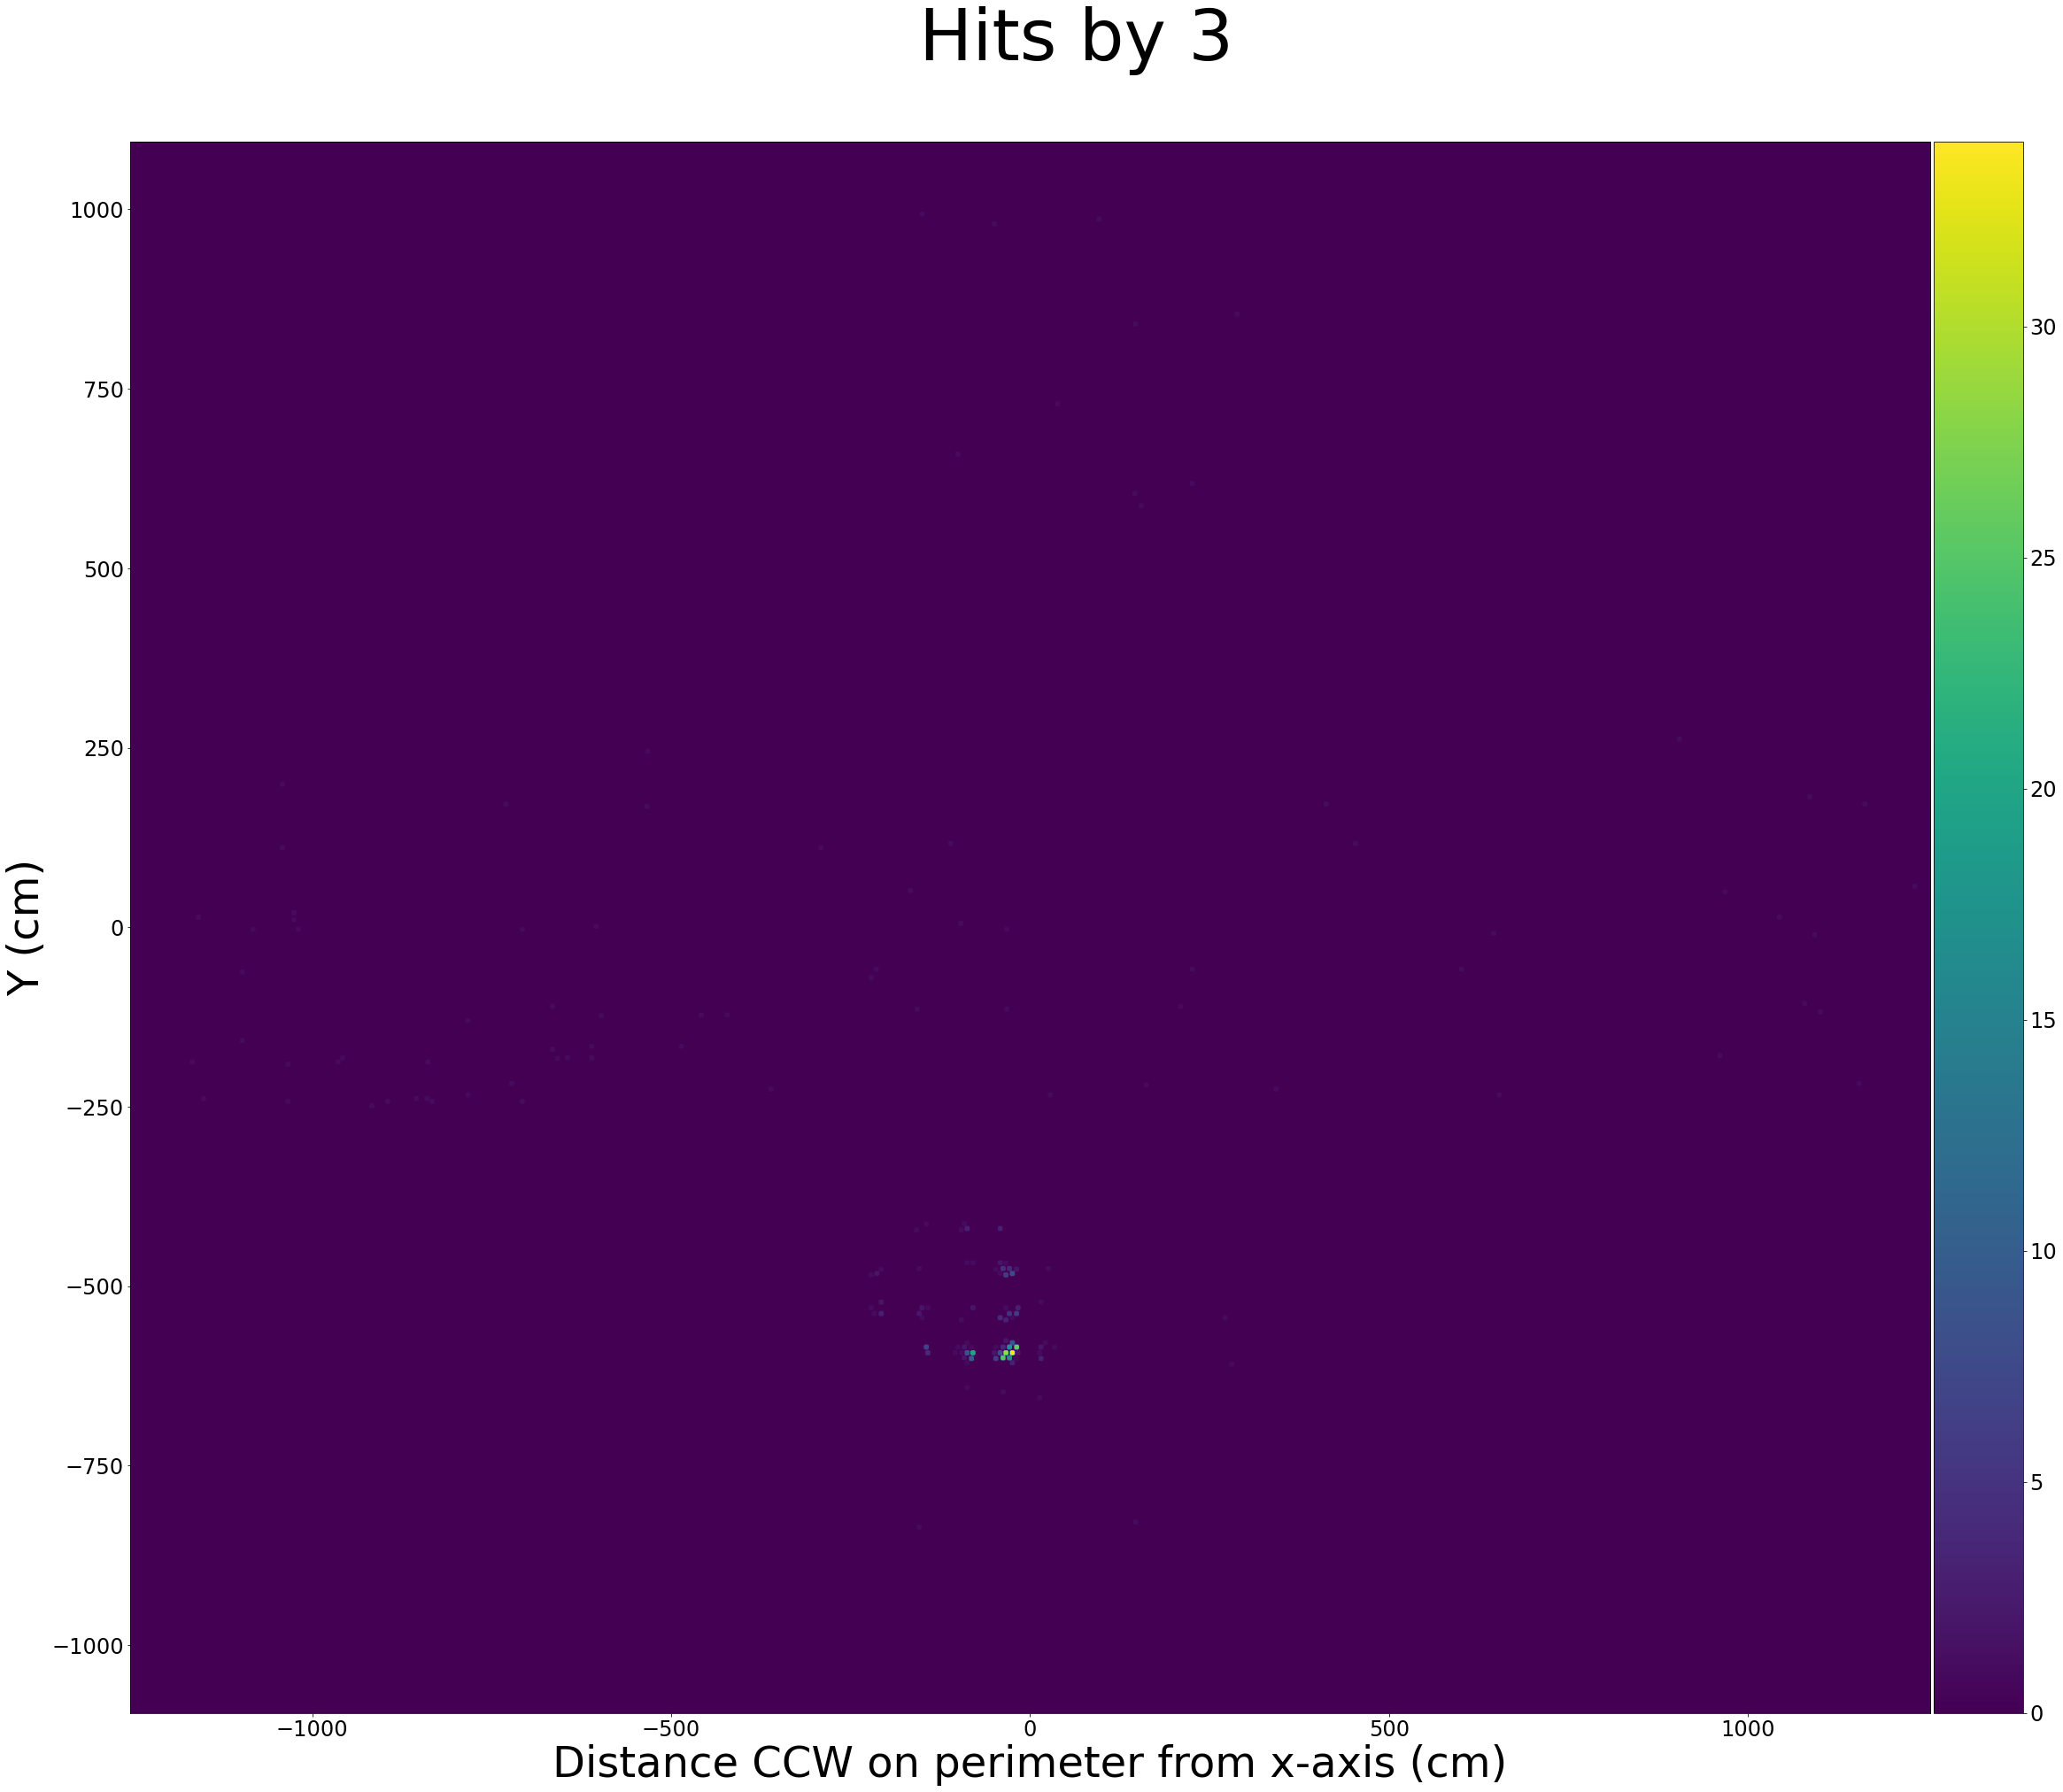

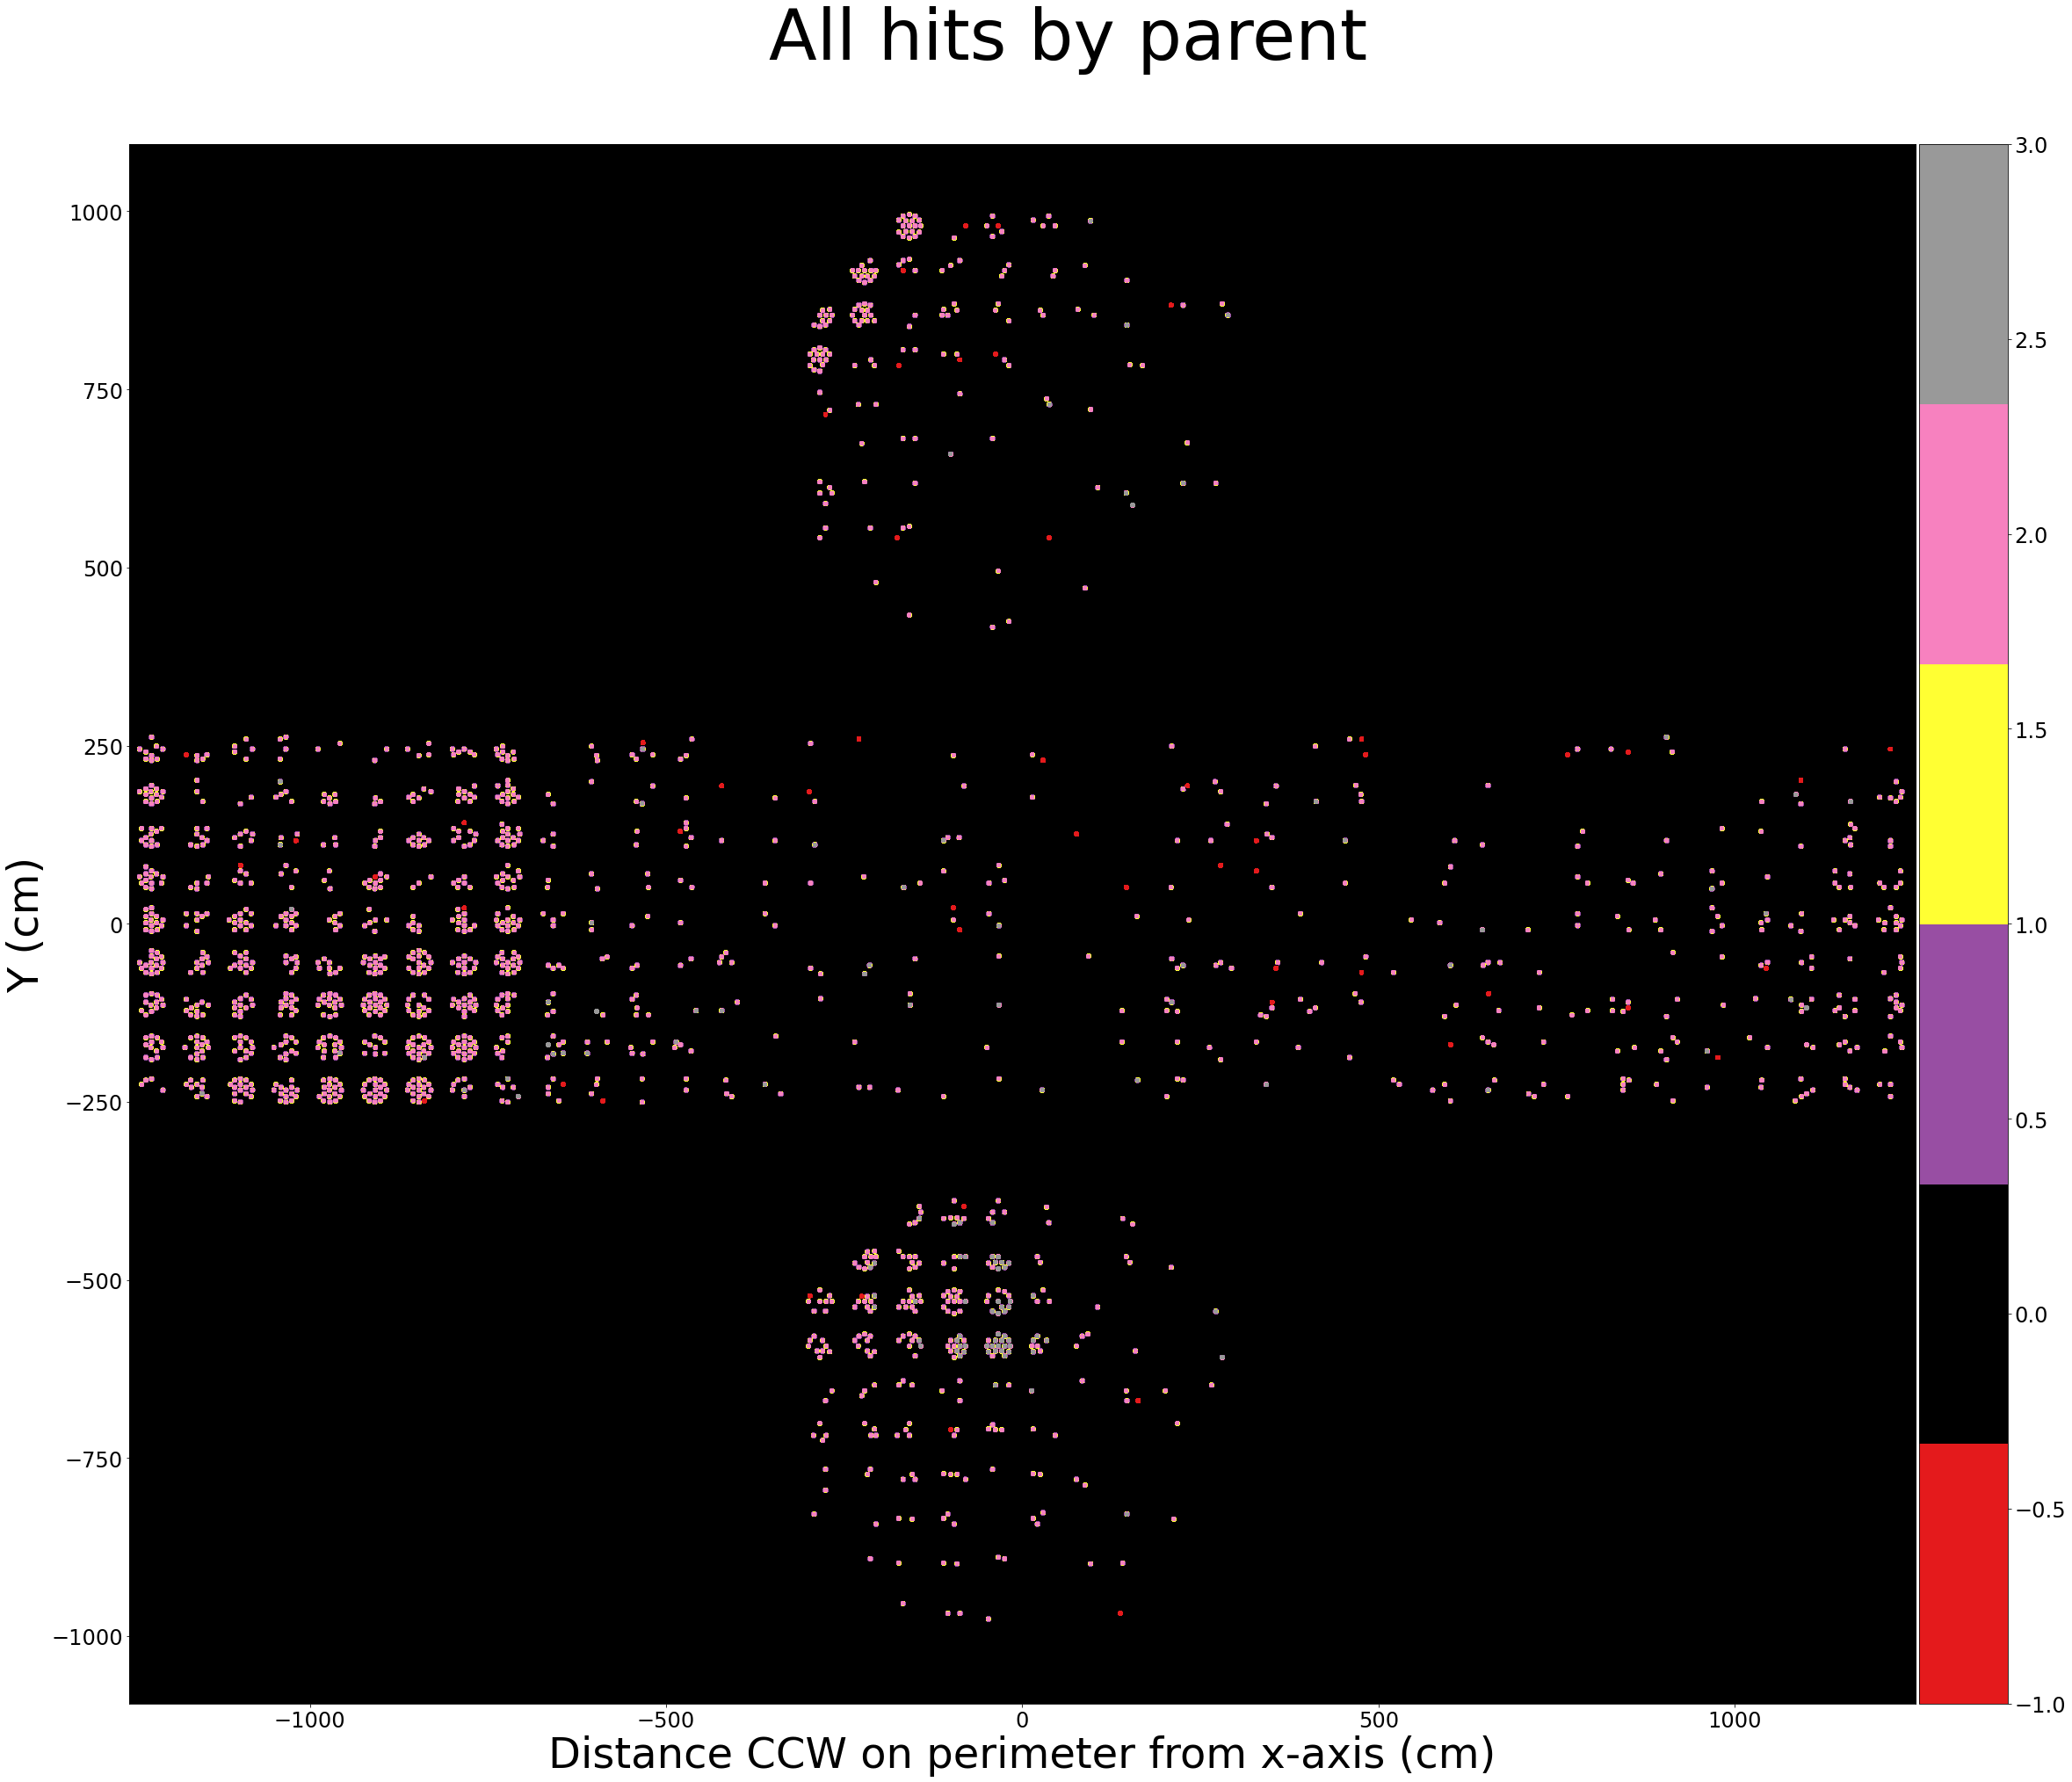

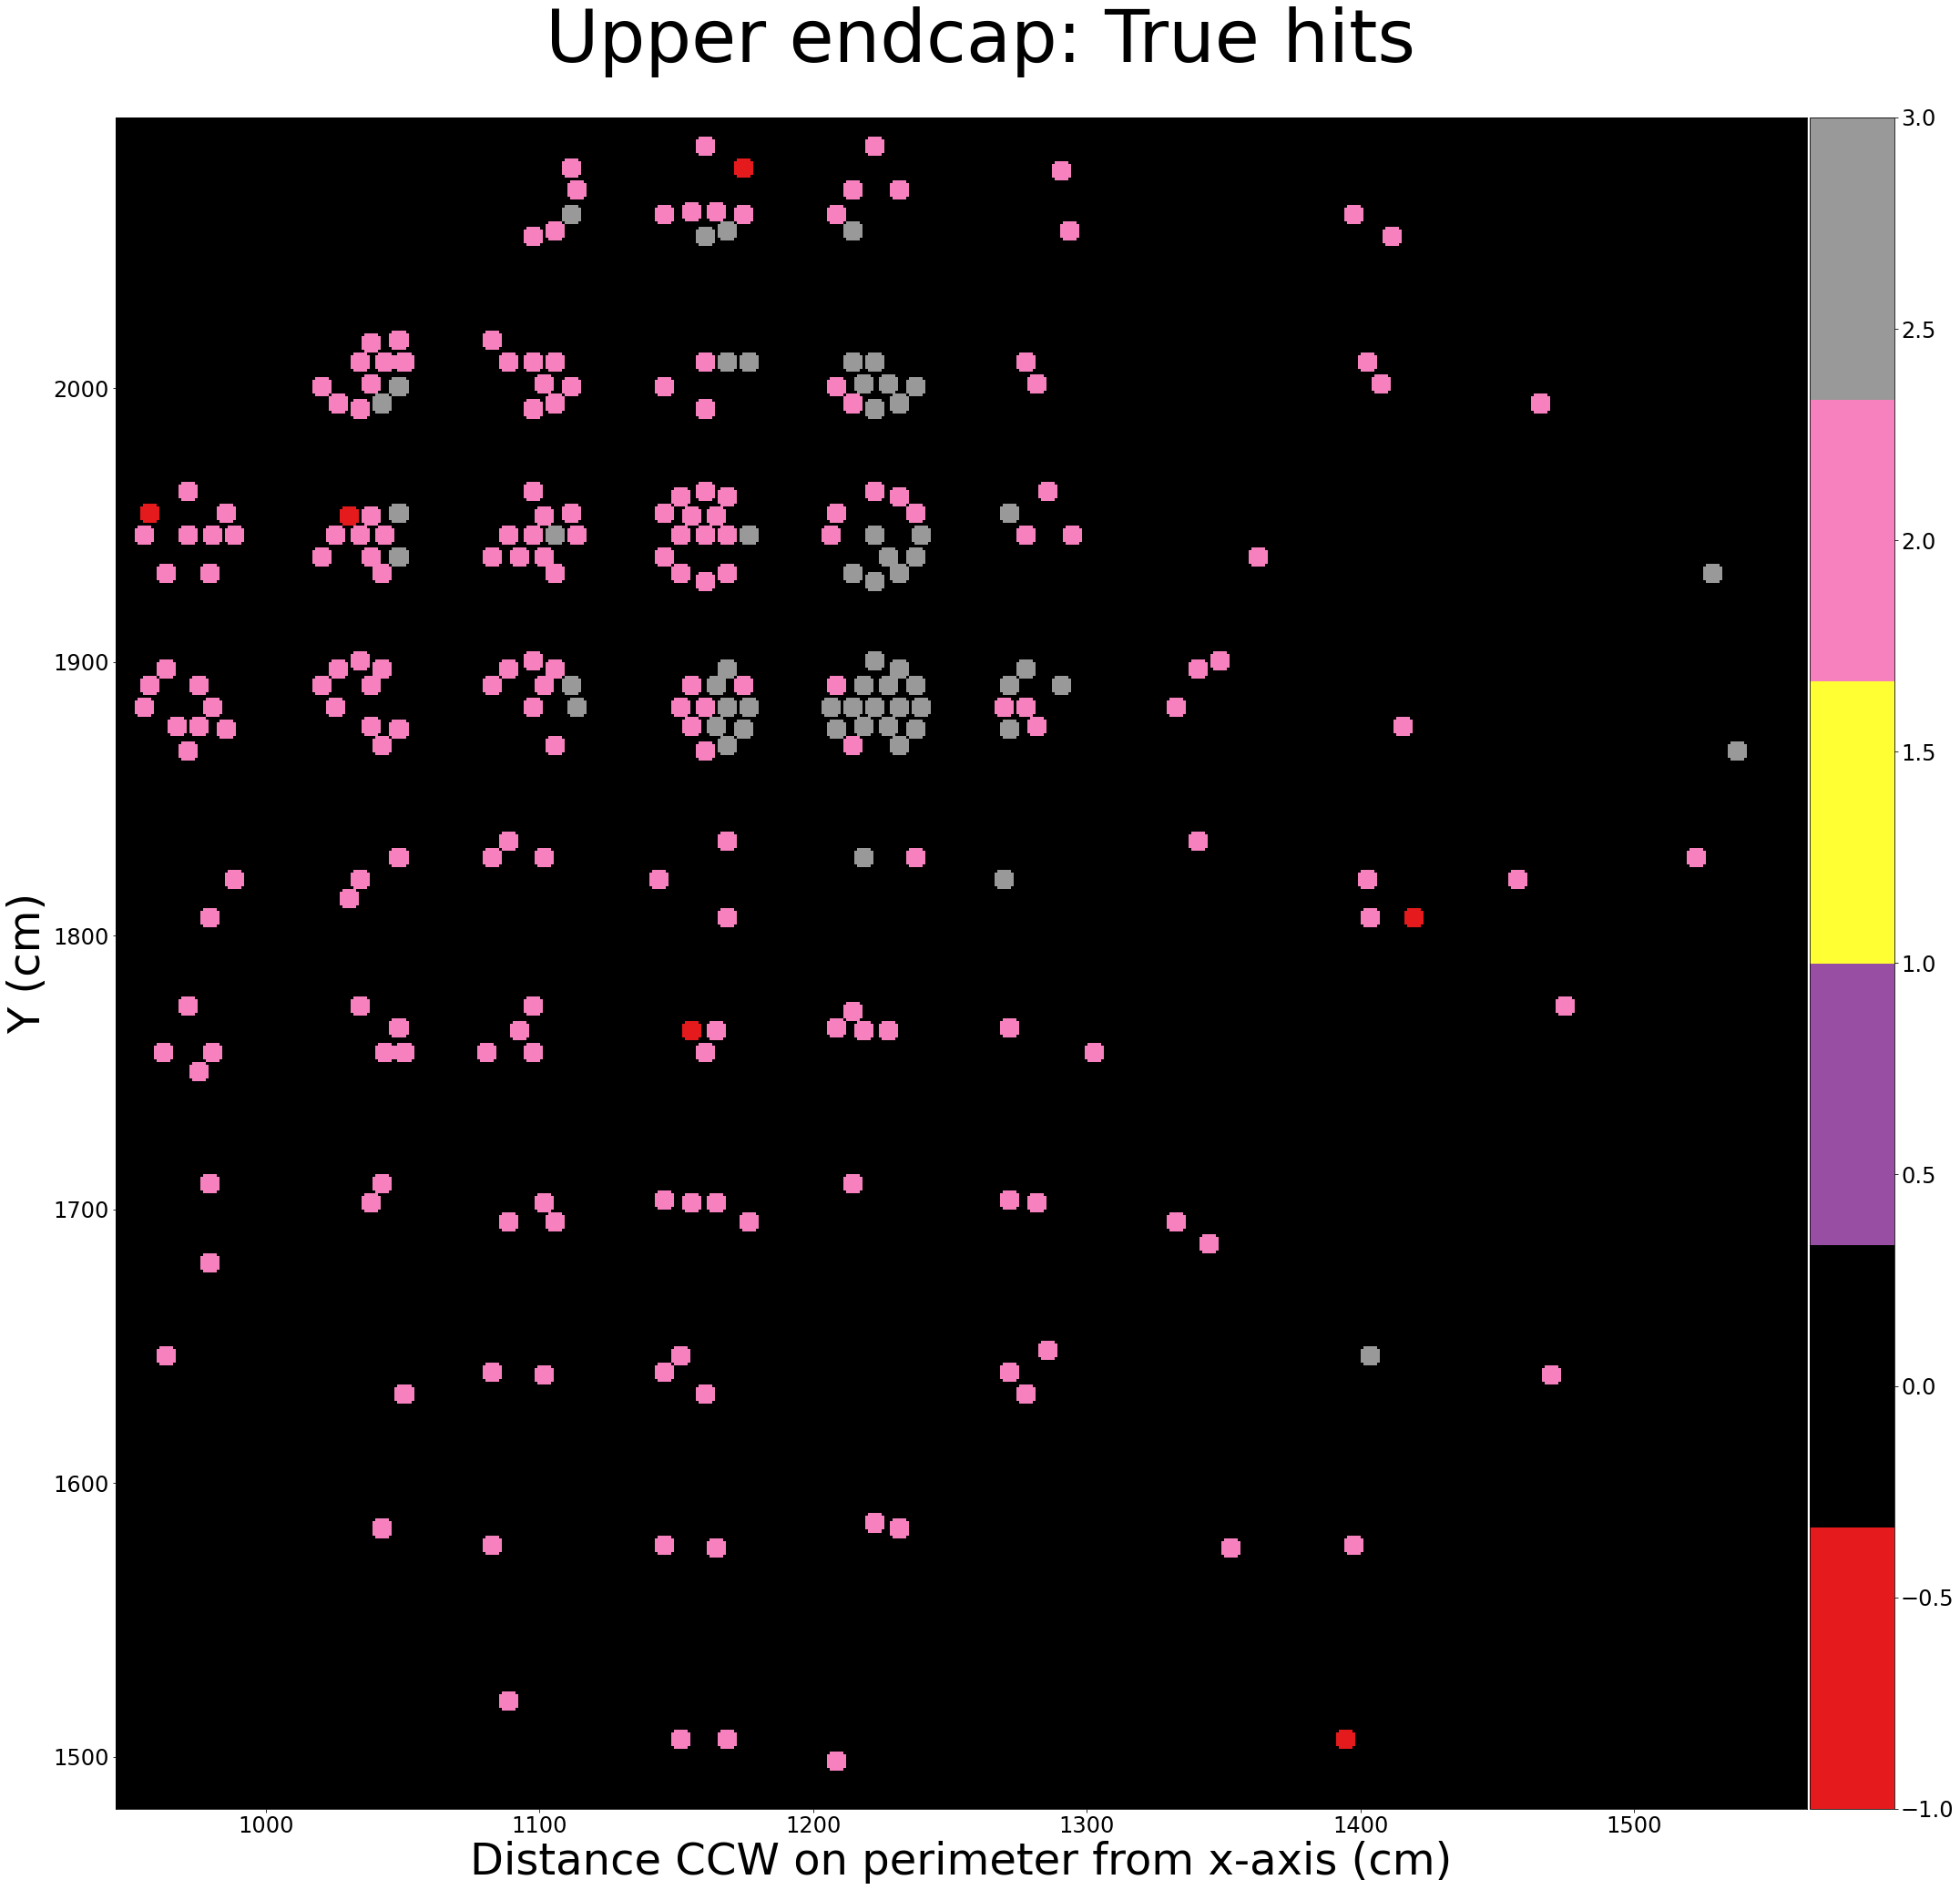

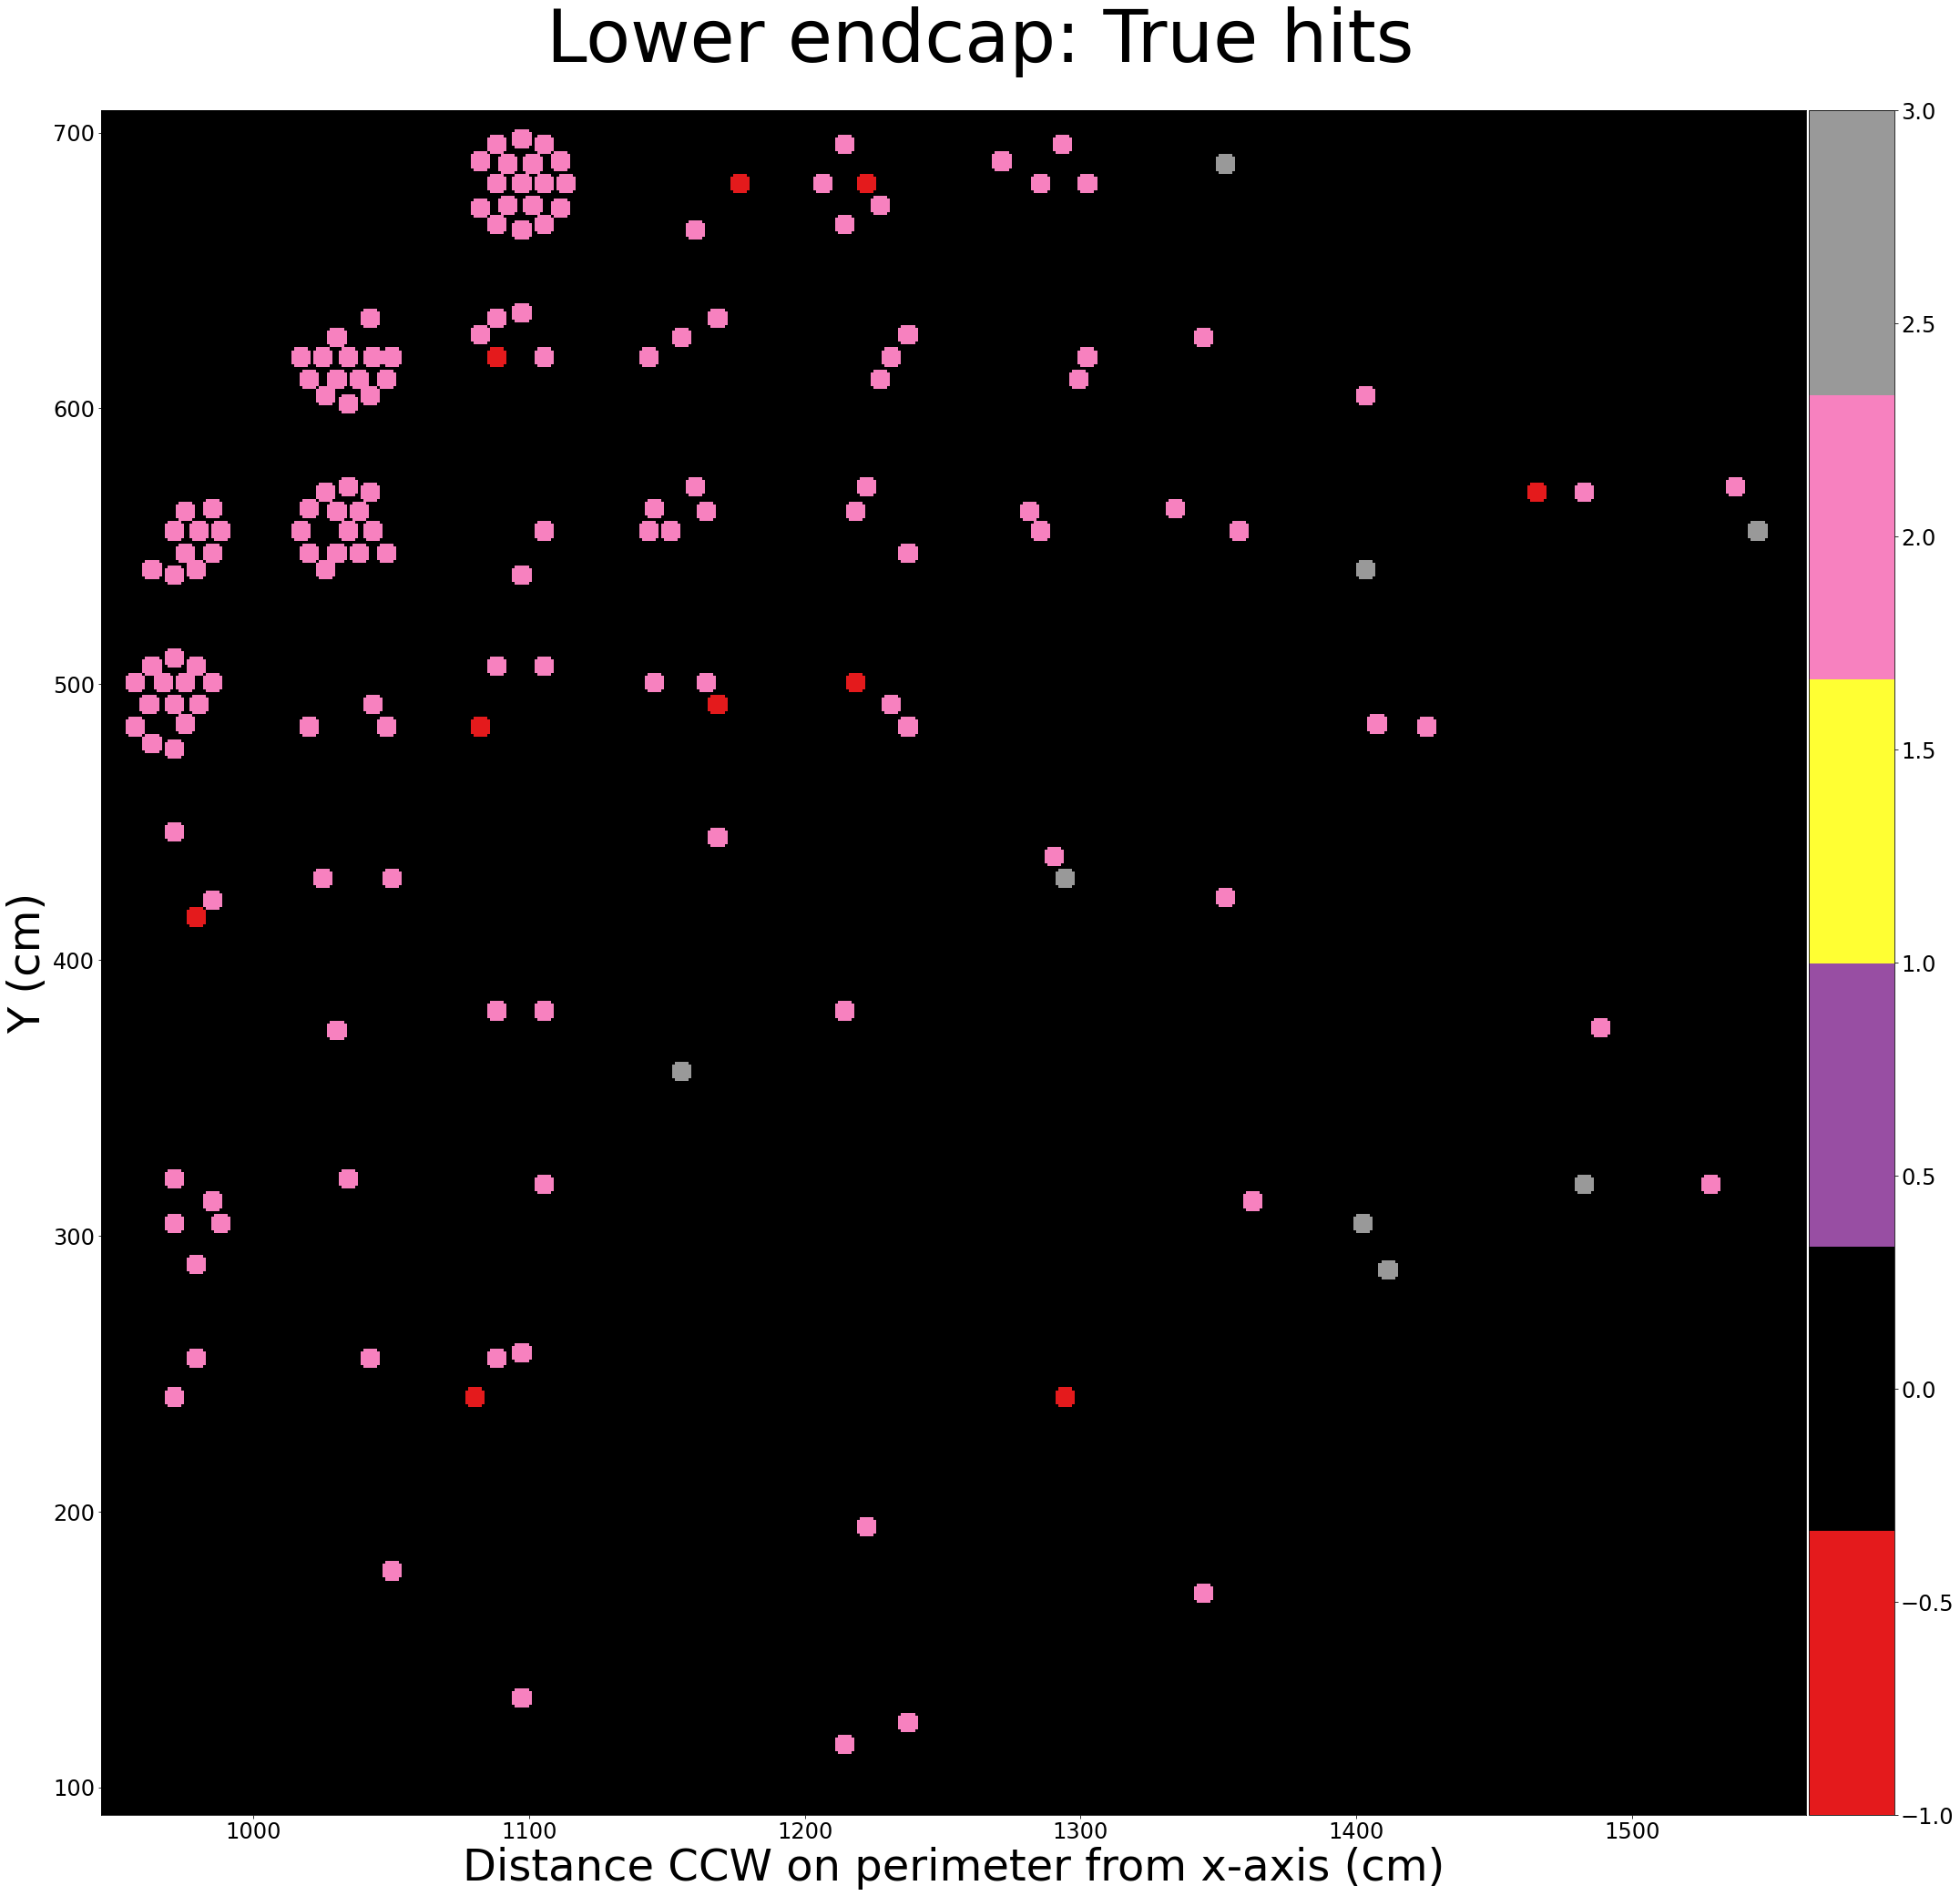

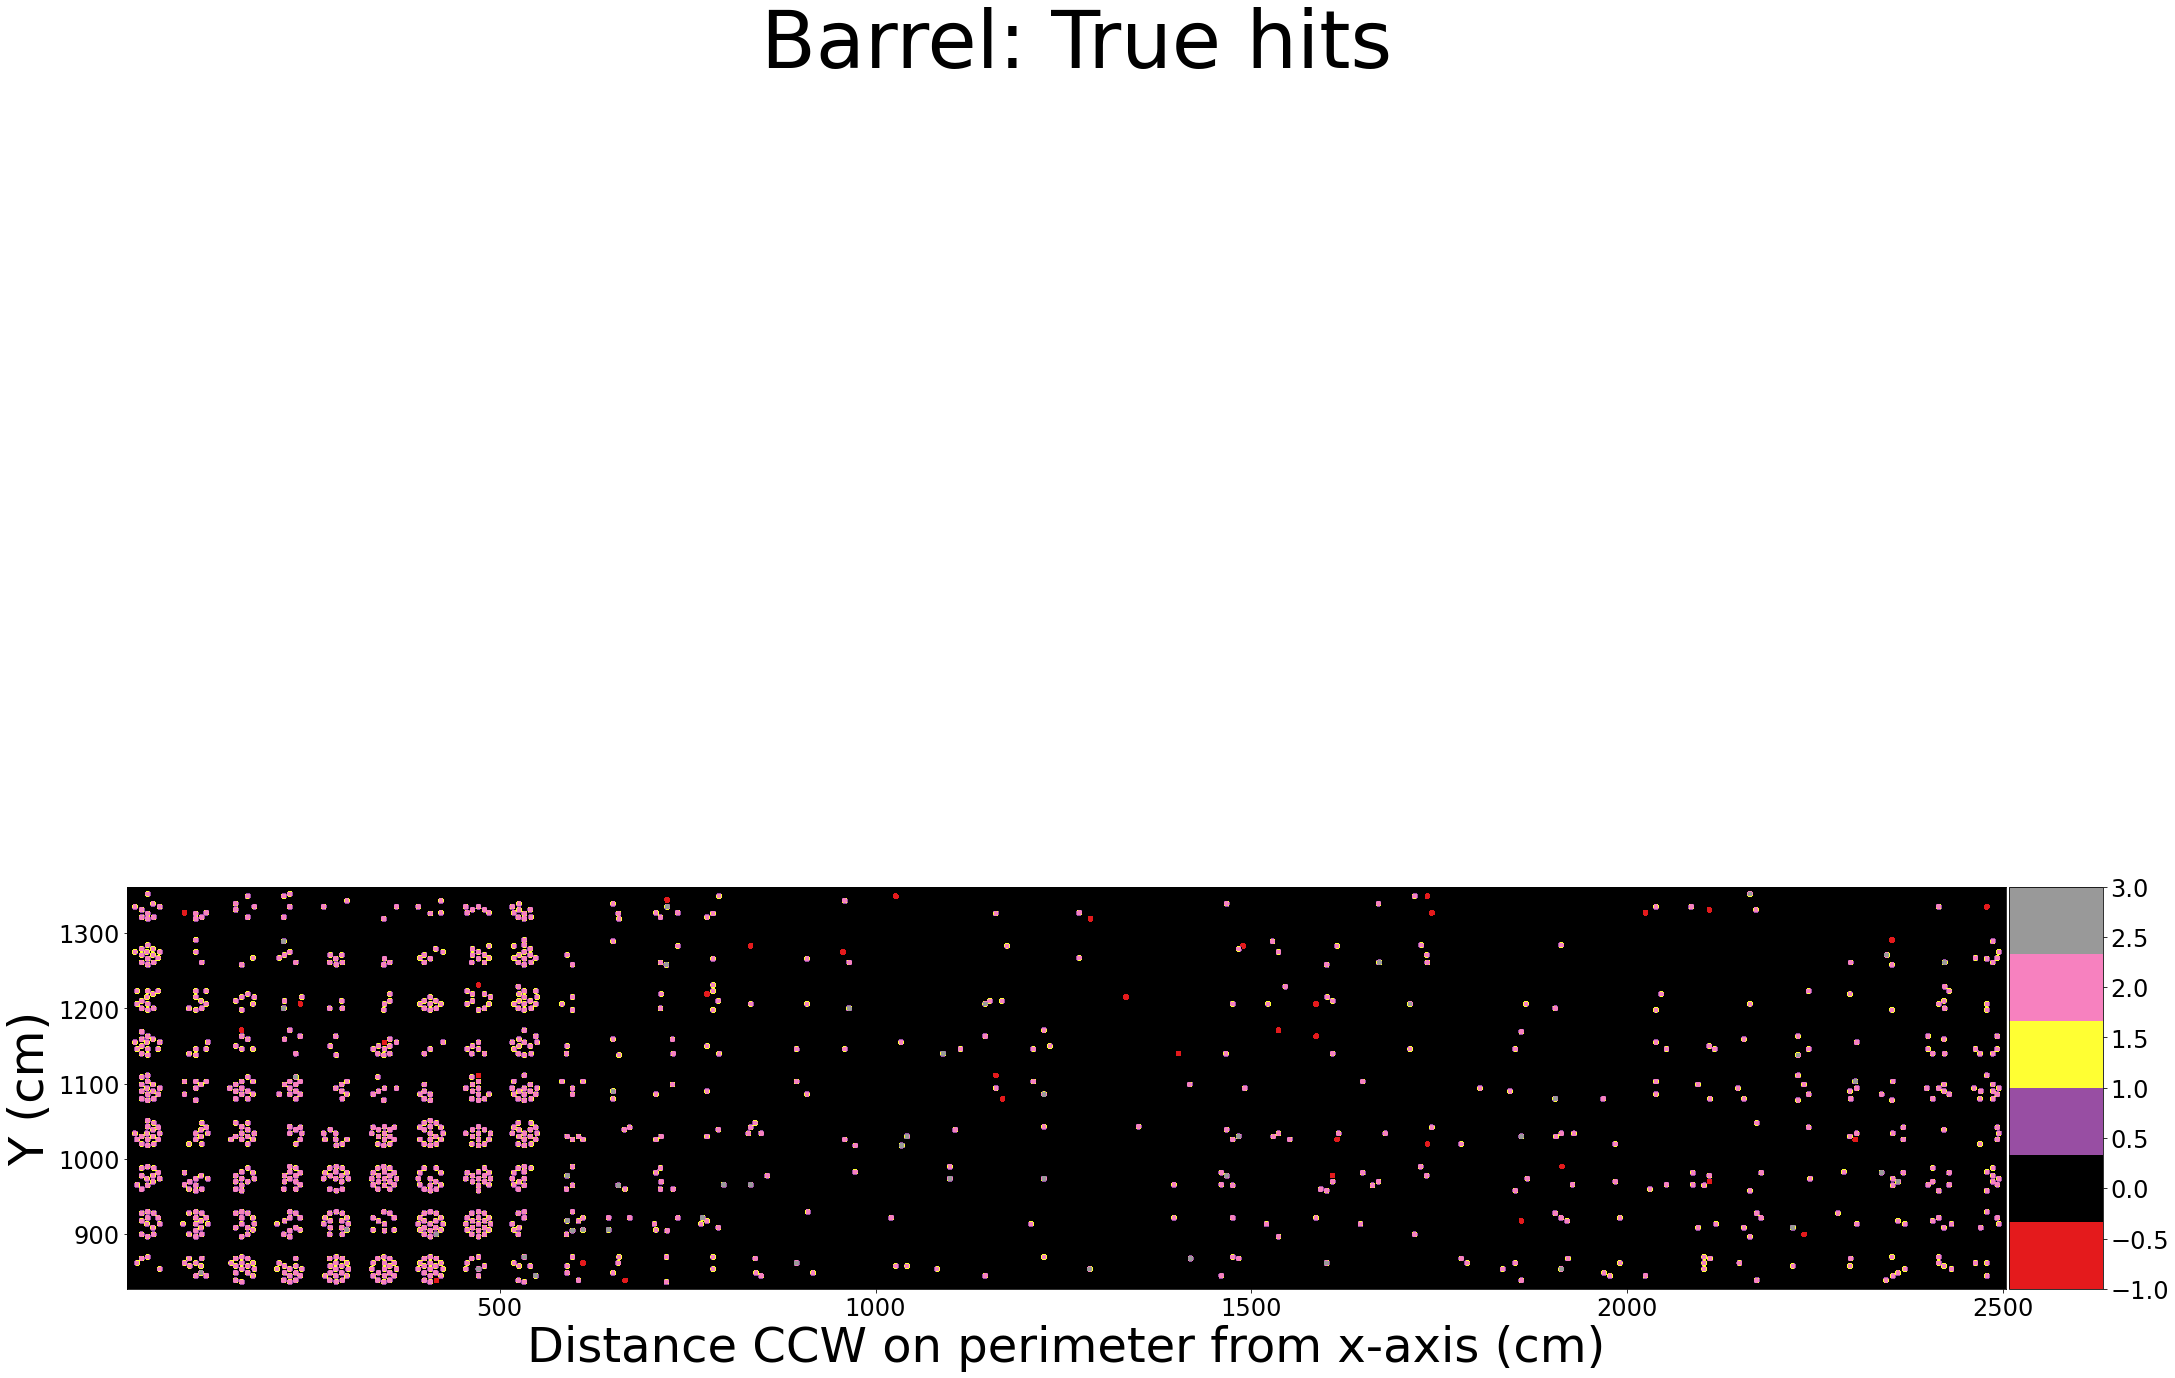

In [56]:
idx = 7234
event_idx = h5_truehits["event_ids"][idx]
file = h5_truehits["root_files"][idx]

plot_from_idx(event_idx, file)